<a href="https://colab.research.google.com/github/juliaviolet/Python_Options/blob/main/BCC_Options_Strategies_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**BCC_Options_Strategies_8 Notebook Summary**

**Introduction & Data Loading**

The notebook begins by loading datasets related to options trading, such as hedging values and trading results. The datasets provide information on different options strategies, their performance, and related metrics.

**Data Cleaning & Preparation**

The notebook conducts preliminary data cleaning by handling missing values and transforming data types. It also calculates additional values like volatility changes and running balances for various strategies.

**Analysis of Hedging Metrics**

The notebook analyzes hedging values like delta, gamma, vega, and theta. It then calculates shadow delta values and combines them with the original values. The impact of including or excluding theta in hedging strategies is also explored.

**Strategy Implementations & Comparisons**

Several options trading strategies are implemented, including:

* Delta and Theta hedging
* Shadow Delta with and without volatility smile adjustment
* Ratio Spread for both calls and puts
* Married Put strategy
* Short Strangle strategy

Each strategy's performance is tracked over time, with running balances calculated to evaluate profitability.

**Visualization**

The notebook uses Plotly to create visualizations that compare the performance of different strategies. These visualizations help in understanding which strategies are most profitable and how they perform over time.

**Conclusions & Findings**

The notebook concludes with insights derived from the analysis:

* how certain strategies outperform others in terms of profitability

* the impact of adjusting for volatility smiles in shadow delta hedging

* the influence of theta in hedging strategies and its implications for profitability

The **Bakshi, Cao, and Chen** (BCC) options pricing model, introduced in 1997, is a significant extension of the Black-Scholes model. It incorporates stochastic volatility and "jumps" in the underlying asset price, aiming to address some of the limitations of the Black-Scholes model. This makes the BCC model more flexible and often more accurate for pricing options in the real world, where markets are not perfectly efficient, i.e. where asset prices can be highly volatile and subject to sudden jumps.

### **BCC Model Hedging Strategies:**

#### **1. Delta Hedging:**
Delta hedging involves buying or selling shares of the underlying asset to offset the delta of an options position. In the BCC model, delta is not constant but changes as the volatility and the underlying asset price change. Delta hedging in this context becomes a dynamic process, requiring frequent adjustments to the hedge ratio as the stochastic volatility and jumps affect the option’s delta.

#### **2. Vega Hedging:**
Vega measures the sensitivity of an option's price to changes in the volatility of the underlying asset. In the BCC model, volatility itself is stochastic, which means that vega hedging needs to account not just for changes in the current volatility, but also for the probability distribution of future volatilities. Vega hedging in the BCC context is more complex because it requires anticipating how the market will price changes in volatility, including sudden jumps, over the option's life.

#### **4. Theta Hedging:**

Theta measures the sensitivity of an option's price to the passage of time, often referred to as "time decay." In traditional options pricing models like Black-Scholes, theta is a relatively straightforward calculation. However, in the context of the BCC model, theta becomes far more complex. This complexity arises because the model incorporates stochastic volatility and price jumps, both of which can dramatically affect an option's value as time passes. Theta hedging, therefore, aims to offset the loss in an option's value due to time decay, while taking into account the stochastic nature of other parameters like volatility and asset price jumps. Given that these elements can change unexpectedly, maintaining a theta hedge requires frequent adjustments and can incur high transaction costs.

#### 3. **Gamma Hedging:**
Gamma is the rate of change of delta with respect to the underlying asset price. Gamma hedging aims to make an options position insensitive to changes in the asset price. In the BCC model, because both volatility and jumps in asset price are stochastic, the gamma of an option will also be a dynamic quantity. This makes gamma hedging more challenging because the hedging strategy has to be continuously updated to account for changes in these parameters.

**Setting Up the BCC Model and Utilities**

1. **Library Imports**: The cell starts by importing essential Python libraries:
    - `numpy` for numerical operations
    - `pandas` for data manipulation
    - `numba` for optimizing numerical computations
    - `scipy.integrate` and `scipy.optimize` for numerical integration and optimization tasks

2. **Characteristic Functions**: Four functions are defined to compute the characteristic functions of different models that are components of the BCC model:
    - `CIR_char_func`: Computes the characteristic function for the Cox-Ingersoll-Ross (CIR) model for interest rates.
    - `H93_char_func`: Computes the characteristic function for the Heston '93 model, which deals with stochastic volatility.
    - `M76_char_func`: Computes the characteristic function for the Merton '76 model, which includes jump diffusion.
    - `BCC_char_func`: Computes the characteristic function for the BCC model, incorporating aspects of the above models, including stochastic volatility and jump diffusion.

These functions compute mathematical entities used in Fourier transform methods for options pricing. The `@njit` decorator optimizes these functions using JIT compilation.

3. **Numerical Integration and Option Pricing**:
    - `BCC_int_func`: This function performs numerical integration of the BCC characteristic function.
    - `BCC_call_value`: Computes the price of a call option using the BCC model.

Functions for numerical integration and option pricing use the characteristic functions to ultimately compute the price of call options using the BCC model.

4. **Data Preparation and Time to Maturity**:
    - The cell reads `sorted_options_data.csv` and separates underlying asset and options data.
    - A new column `T` is added to represent time to maturity for each option.

5. **Optimization Setup**:
    - `objective`: Defines an objective function that computes the sum of squared differences between the market and model prices.
    - Initial parameters and bounds for the optimization are also specified.

6. **Pricing and Data Export**:
    - The model prices of options based on initial parameters are calculated and added to a new column `MODEL_PRICE`.
    - Market prices for call and put options are calculated and stored in `MARKET_PRICE`.
    - The resulting data frame is exported to a CSV file named `simply_optimal_options_data.csv`.

This initial code lays the foundation for the subsequent analysis, importing necessary modules, defining key functions, and preparing the data.



In [ ]:
import numpy as np
import pandas as pd
from numba import njit
from scipy.integrate import quad
from scipy.optimize import minimize

#Defining the required functions for the M76, H93, BCC model
# Valuation of European Call and Put Options
# Under Stochastic Volatility and Jumps
# 09_gmm/BCC_option_valuation.py
#
# (c) Dr. Yves J. Hilpisch
# Derivatives Analytics with Python

#characteristic function of the CIR model for interest rates.

@njit
def CIR_char_func(u, T, kappa, theta, sigma_r, r0):
    gamma = np.sqrt(kappa**2 + 2*sigma_r**2*u*1j)
    A = 2*gamma*np.exp((kappa+gamma)*T/2) / (2*gamma+(gamma+kappa)*(np.exp(gamma*T)-1))
    B = 2*(np.exp(gamma*T)-1) / (2*gamma+(gamma+kappa)*(np.exp(gamma*T)-1))
    char_func_value = np.exp(A*theta-B*r0)
    return char_func_value

#Heston '93 characteristic function
@njit
def H93_char_func(u, T, r0, kappa_v, theta_v, sigma_v, rho, v0):
    c1 = kappa_v * theta_v
    c2 = -np.sqrt((rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v ** 2 * (-u * 1j - u ** 2))
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (kappa_v - rho * sigma_v * u * 1j - c2)
    H1 = (r0 * u * 1j * T + (c1 / sigma_v ** 2) * ((kappa_v - rho * sigma_v * u * 1j + c2) * T - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))))
    H2 = ((kappa_v - rho * sigma_v * u * 1j + c2) / sigma_v ** 2 * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T))))
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

#Merton '76 characteristic function, jump diffusion
@njit
def M76_char_func(u, T, lamb, mu, delta):
    omega = -lamb * (np.exp(mu + 0.5 * delta ** 2) - 1)
    char_func_value = np.exp((1j * u * omega + lamb * (np.exp(1j * u * mu - u ** 2 * delta ** 2 * 0.5) - 1)) * T)
    return char_func_value

#Bakshi, Cao and Chen '97 characteristic function, jump diffusion + stochastic volatility
@njit
def BCC_char_func(u, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ):
    CIR1 = CIR_char_func(u, T, kappa, theta, sigma_r, r0)
    BCC1 = H93_char_func(u, T, r0, kappa_v, theta_v, sigma_v, rho, v0)
    BCC2 = M76_char_func(u, T, lamb, mu, delta)
    jumpVolatilityPart = lamb * (np.exp(1j * u * muV * deltaV) - 1) * T
    return CIR1 * BCC1 * BCC2 * np.exp(jumpVolatilityPart * rhoJ)

#numerical integration of BCC_char_func
@njit
def BCC_int_func(u, S0, K, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ):
    char_func_value = BCC_char_func(u - 1j * 0.5, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ)
    int_func_value = 1 / (u ** 2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    return int_func_value

#call option price calculation using the BCC model
def BCC_call_value(S0, K, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ):
    int_value = quad(lambda u: BCC_int_func(u, S0, K, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ), 0, np.inf, limit=250)[0]
    call_value = max(0, S0 - np.exp(-r0 * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

# Read the data
file_path = 'sorted_options_data.csv'
options_data = pd.read_csv(file_path)

# Separate the underlying and option data
underlying_data = options_data.iloc[0]
options_data = options_data.iloc[1:]

# Calculate the time to maturity for each option
options_data['T'] = (pd.to_datetime(options_data['EXPIR_DATE']) - pd.to_datetime(options_data['CF_DATE'])).dt.days / 365.25

# Reset the indices
options_data = options_data.reset_index(drop=True)

# Initial interest rate
r0 = -0.00067

# Define the objective function to accommodate the stochastic interest rate
def objective(params, option_type, options_data):
    kappa, theta, sigma_r, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, muV, deltaV, rhoJ = params
    sum_squared_errors = 0
    for idx, row in options_data.iterrows():
        if row['PUTCALLIND'] == option_type:
            model_price = BCC_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'],
                                         kappa=kappa, theta=theta, sigma_r=sigma_r, r0=r0,
                                         kappa_v=kappa_v, theta_v=theta_v, sigma_v=sigma_v, rho=rho, v0=v0,
                                         lamb=lamb, mu=mu, delta=delta, muV=muV, deltaV=deltaV, rhoJ=rhoJ)
            market_price = np.maximum(row['CF_CLOSE'] - row['STRIKE_PRC'], 0) if option_type == 'CALL' else np.maximum(row['STRIKE_PRC'] - row['CF_CLOSE'], 0)
            sum_squared_errors += (model_price - market_price) ** 2
    return sum_squared_errors

# Define the initial parameters
initial_params = [3.76807610e+00, 1.00000000e-03, 8.77986615e-03, 5.67355018e-03,
 4.16586532e+00, 2.29651712e-03, 1.14133804e-02, 5.03063522e-01,
 0.00000000e+00, 3.95979221e-01, 7.10854746e-02, 4.01539560e-02,
 6.99623759e-02, 9.99763692e-02, 5.00002718e-01]

# Bounds for the parameters
bounds = [(0.1, 10),    # kappa
    (0.001, 0.03), # theta
    (0.001, 0.03), # sigma_r
    (-0.01, 0.01), # r0
    (0.1, 10),    # kappa_v
    (0.001, 0.03), # theta_v
    (0.001, 0.03), # sigma_v
    (-1, 1),      # rho
    (0, 0.1),     # v0
    (0, 2),       # lamb
    (-1, 1),      # mu
    (0, 1),       # delta
    (-1, 1),      # muV
    (0, 1),       # deltaV
    (-1, 1)       # rhoJ
]

# Selecting options in a specific range for demonstration
options_in_range = options_data.copy()

# Price the options using the initial parameters
for idx, row in options_in_range.iterrows():
    if row['PUTCALLIND'] == 'CALL':
        model_price = BCC_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'],
                                     r0=initial_params[3], kappa_v=initial_params[4], theta_v=initial_params[5],
                                     sigma_v=initial_params[6], rho=initial_params[7], v0=initial_params[8],
                                     lamb=initial_params[9], mu=initial_params[10], delta=initial_params[11],
                                     kappa=initial_params[0], theta=initial_params[1], sigma_r=initial_params[2],
                                     muV=initial_params[12], deltaV=initial_params[13], rhoJ=initial_params[14])
    else:
        call_price = BCC_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'], r0=initial_params[3],
                                    kappa=initial_params[0], theta=initial_params[1], sigma_r=initial_params[2],
                                    kappa_v=initial_params[4], theta_v=initial_params[5], sigma_v=initial_params[6], rho=initial_params[7], v0=initial_params[8],
                                    lamb=initial_params[9], mu=initial_params[10], delta=initial_params[11], muV=initial_params[12], deltaV=initial_params[13], rhoJ=initial_params[14])
        model_price = call_price + row['STRIKE_PRC']*np.exp(-r0*row['T']) - row['CF_CLOSE']

    options_in_range.loc[idx, 'MODEL_PRICE'] = model_price

options_in_range

# Calculate the market price for both call and put options
options_in_range['MARKET_PRICE'] = 0
options_in_range.loc[options_in_range['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_in_range.loc[options_in_range['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_in_range.loc[options_in_range['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = options_in_range.loc[options_in_range['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Print the options data with model prices and market prices
print(options_in_range)
data = options_in_range
data.to_csv('simply_optimal_options_data.csv', index=False)

<ipython-input-2-7be554d71811>:61: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: BCC_int_func(u, S0, K, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ), 0, np.inf, limit=250)[0]
<ipython-input-2-7be554d71811>:61: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, disconti

     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
0           233  /GDAX118000F0.EX  2020-05-15  2020-06-19       CALL   
1           231  /GDAX117500F0.EX  2020-05-15  2020-06-19       CALL   
2           235  /GDAX118500F0.EX  2020-05-14  2020-06-19       CALL   
3           237  /GDAX119000F0.EX  2020-05-14  2020-06-19       CALL   
4           229  /GDAX117000F0.EX  2020-05-15  2020-06-19       CALL   
..          ...               ...         ...         ...        ...   
373           7   /GDAX41000F0.EX  2020-05-15  2020-06-19       CALL   
374           5   /GDAX40000F0.EX  2020-03-09  2020-06-19       CALL   
375           3   /GDAX36000F0.EX  2020-03-17  2020-06-19       CALL   
376           2   /GDAX20000R0.EX  2020-04-30  2020-06-19       PUT    
377           1   /GDAX20000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT         T  MODEL_PRICE  MARKET_PRICE  
0       11800.0      12.2     23.22  0.095825     0.000000  

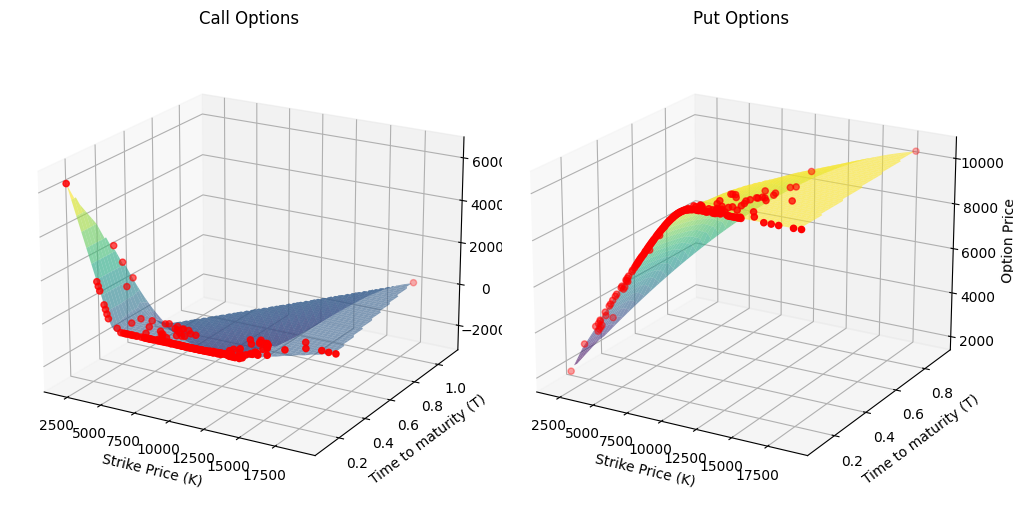

In [ ]:
import numpy as np
import pandas as pd
from numba import njit
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.interpolate import griddata

# Read the data
file_path = 'simply_optimal_options_data.csv'
options_data = pd.read_csv(file_path)

# Calculate time to expiration
options_data['T'] = (pd.to_datetime(options_data['EXPIR_DATE']) - pd.to_datetime(options_data['CF_DATE'])).dt.days / 365.25

# Calculate the market price for both call and put options
options_data['MARKET_PRICE'] = 0
options_data.loc[options_data['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_data.loc[options_data['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Separate the data into call and put options
call_options = options_data[options_data['PUTCALLIND'] == 'CALL']
put_options = options_data[options_data['PUTCALLIND'] == 'PUT ']

# Define the variables for Strike Prices and Time to Maturity for calls and puts
K_call, T_call = call_options['STRIKE_PRC'].values, call_options['T'].values
K_put, T_put = put_options['STRIKE_PRC'].values, put_options['T'].values

# Create a mesh grid for T and K for calls and puts
K_grid_call, T_grid_call = np.meshgrid(np.linspace(min(K_call), max(K_call), 100), np.linspace(min(T_call), max(T_call), 100))
K_grid_put, T_grid_put = np.meshgrid(np.linspace(min(K_put), max(K_put), 100), np.linspace(min(T_put), max(T_put), 100))

# Create a new figure
fig = plt.figure(figsize=(10, 6))

# Create 3D plots for call options
ax1 = fig.add_subplot(121, projection='3d')
model_price_grid_call = griddata((K_call, T_call), call_options['MODEL_PRICE'], (K_grid_call, T_grid_call), method='cubic')
ax1.plot_surface(K_grid_call, T_grid_call, model_price_grid_call, cmap='viridis', alpha=0.6)
ax1.scatter(K_call, T_call, call_options['MARKET_PRICE'], color='r', marker='o', s=20)
ax1.set_title('Call Options')
ax1.set_xlabel('Strike Price (K)')
ax1.set_ylabel('Time to maturity (T)')
ax1.set_zlabel('Option Price', rotation=90)
ax1.view_init(20, -60)  # Adjust the viewing angle for better visualization

# Create 3D plots for put options
ax2 = fig.add_subplot(122, projection='3d')
model_price_grid_put = griddata((K_put, T_put), put_options['MODEL_PRICE'], (K_grid_put, T_grid_put), method='cubic')
ax2.plot_surface(K_grid_put, T_grid_put, model_price_grid_put, cmap='viridis', alpha=0.6)
ax2.scatter(K_put, T_put, put_options['MARKET_PRICE'], color='r', marker='o', s=20)
ax2.set_title('Put Options')
ax2.set_xlabel('Strike Price (K)')
ax2.set_ylabel('Time to maturity (T)')
ax2.set_zlabel('Option Price', rotation=90)
ax2.view_init(20, -60)  # Adjust the viewing angle for better visualization

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import plotly.express as px

# Read the data
file_path = 'simply_optimal_options_data.csv'
options_data = pd.read_csv(file_path)

# Skip the underlying asset info
underlying_asset = options_data.iloc[0]
options_data = options_data.iloc[1:]

# Calculate the market price for each option
options_data['MARKET_PRICE'] = 0
options_data.loc[options_data['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_data.loc[options_data['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Calculate the percentage error between the model and market prices
options_data['PERCENTAGE_ERROR'] = abs((options_data['MODEL_PRICE'] - options_data['MARKET_PRICE']) / options_data['MARKET_PRICE'] * 100)

# Correct infinite percentage errors due to division by zero
options_data.loc[options_data['PERCENTAGE_ERROR'] == float('inf'), 'PERCENTAGE_ERROR'] = None

# Define a threshold for what you consider a "reasonable" error
threshold = 5.0

# Add a new column indicating if the percentage error is outside the threshold
options_data['OUTSIDE_THRESHOLD'] = options_data['PERCENTAGE_ERROR'] > threshold

# Create a new column combining option type and threshold status
options_data['OPTION_STATUS'] = options_data.apply(lambda row: row['PUTCALLIND'].strip() + (' Outside' if row['OUTSIDE_THRESHOLD'] else ' Inside'), axis=1)

# Extract relevant columns
result = options_data[['OPTION_STATUS', 'IMP_VOLT', 'PERCENTAGE_ERROR', 'MODEL_PRICE']]

# Create a scatter plot with facets
fig = px.scatter(result,
                 x='MODEL_PRICE',
                 y='IMP_VOLT',
                 color='PERCENTAGE_ERROR',
                 facet_col='OPTION_STATUS',
                 title='Option Prices vs. Implied Volatility',
                 labels={'MODEL_PRICE': 'Option Price', 'IMP_VOLT': 'Implied Volatility', 'OPTION_STATUS': 'Option Type & Status'},
                 color_continuous_scale='viridis',
                 hover_data=['OPTION_STATUS', 'PERCENTAGE_ERROR'])

# Modify the marker aesthetics
fig.update_traces(marker=dict(size=10, opacity=0.8, line=dict(width=1, color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

# Update facet titles
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))

# Show the plot
fig.show()


The underlying asset data is sorted to implement the hedging strategies.


In [ ]:
#underlying asset price at market close from MarketWatch https://www.marketwatch.com/investing/index/dax/download-data?startDate=05/15/2019&endDate=05/15/2020&countryCode=dx

# Import the data
file_path = 'updated_merged_data_fixed.csv'
updated_merged_data_fixed = pd.read_csv(file_path)

# Skip the first row and sort the rest by 'CF_DATE' in ascending order
sorted_data = updated_merged_data_fixed.iloc[1:].sort_values(by='CF_DATE', ascending=True)

# Output the sorted DataFrame to a new CSV file
sorted_file_path = 'sorted_updated_merged_data_fixed.csv'
sorted_data.to_csv(sorted_file_path, index=False)

sorted_file_path

'sorted_updated_merged_data_fixed.csv'

Given that delta measures an option's sensitivity to changes in the price of the underlying asset, vega to changes in implied volatility, gamma to the rate of change of the option's delta, and theta to time decay, a hedging strategy that integrates all four can be very effective.

Here's a comprehensive approach:

### 1. **Delta Hedging**:
- **Purpose**: To make the option's price movement insensitive to the underlying's price movement.
- **Strategy**: If you're long (i.e., you've bought) an option, you can hedge the delta by taking a short position in the underlying asset. If you're short an option, you take a long position in the underlying.
- **Implementation**: The number of units of the underlying to buy or sell is given by the value of the option's delta. For instance, a delta of -0.5 for a long option position indicates you should short 0.5 units of the underlying for each option contract.

### 2. **Vega Hedging**:
- **Purpose**: To make the option's price movement insensitive to changes in implied volatility.
- **Strategy**: If you're long an option with a positive vega, you can hedge against an increase in implied volatility by shorting another option (either a call or a put) with a similar positive vega.
- **Implementation**: The choice of which option to short should be based on the option's vega, time to expiration, and strike price.

### 3. **Gamma Hedging**:
- **Purpose**: To make the option's price movement insensitive to rapid changes in the underlying's price movement.
- **Strategy**: If you're long an option, you can hedge the gamma by taking positions in options that have opposite gammas. This will offset the change in delta as the underlying price moves.
- **Implementation**: The amount and type of options to use for gamma hedging can be determined by the magnitude and sign of the gamma you are trying to hedge.

### 4. **Theta Hedging (Time Decay)**:
- **Purpose**: To counteract the loss of an option's value due to time decay.
- **Strategy**: Options closer to expiration will have a larger negative theta (for long positions). To hedge against this, you can:
    - Buy options with more time until expiration. These will have a smaller negative theta (i.e., they will lose value more slowly).
    - Short options with higher implied volatility. These will have a higher theta, meaning they will lose value faster. By shorting them, you profit from this rapid time decay.
- **Implementation**: Regularly roll over your options to longer-dated ones as they approach expiration.

---

For a more precise hedging strategy, it's essential to dynamically adjust these hedges as market conditions change. This is known as "dynamic hedging," and it involves regularly rebalancing a portfolio to ensure that Greek exposures (delta, vega, gamma, theta) remain neutral.

**Time Bump, Interest Rate, and Redefining Functions**

This code will focus on setting up additional parameters and redefining some of the previously defined functions for specific computations.

1. **Library Imports**: Re-imports `numpy`, `pandas`, and `scipy.integrate` for numerical operations and integration.
  
2. **Time Bump for Theta**: Defines a variable `time_bump` that represents a small increment in time, likely for calculating theta (the sensitivity of the option's price to the passage of time).
  
3. **Interest Rate**: Sets a variable `r0` for the initial interest rate, with a value of `-0.00067`. This rate is crucial for discounting future cash flows and is used in options pricing calculations.
  
4. **Redefining Functions**: Redefines some of the characteristic functions without JIT compilation, for specific calculations related to the Greeks.

This cell further fine-tunes the setup for options pricing and hedging strategies. It introduces additional parameters and refines existing functions to make them compatible with the calculations of the Greeks' values.

In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import quad

# Time bump for theta calculation
time_bump = 1 / 365.25

#https://www.marketwatch.com/investing/bond/tmbmkde-10y/download-data?startDate=05/14/2019&endDate=05/14/2020&countryCode=BX
r0 = -0.00067

# Redefining the functions without JIT compilation for Gamma calculation
def CIR_char_func_nojit(u, T, kappa, theta, sigma_r, r0):
    gamma = np.sqrt(kappa**2 + 2*sigma_r**2*u*1j)
    A = 2*gamma*np.exp((kappa+gamma)*T/2) / (2*gamma+(gamma+kappa)*(np.exp(gamma*T)-1))
    B = 2*(np.exp(gamma*T)-1) / (2*gamma+(gamma+kappa)*(np.exp(gamma*T)-1))
    char_func_value = np.exp(A*theta-B*r0)
    return char_func_value

def H93_char_func_nojit(u, T, r0, kappa_v, theta_v, sigma_v, rho, v0):
    c1 = kappa_v * theta_v
    c2 = -np.sqrt((rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v ** 2 * (-u * 1j - u ** 2))
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (kappa_v - rho * sigma_v * u * 1j - c2)
    H1 = (r0 * u * 1j * T + (c1 / sigma_v ** 2) * ((kappa_v - rho * sigma_v * u * 1j + c2) * T - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))))
    H2 = ((kappa_v - rho * sigma_v * u * 1j + c2) / sigma_v ** 2 * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T))))
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

def M76_char_func_nojit(u, T, lamb, mu, delta):
    omega = -lamb * (np.exp(mu + 0.5 * delta ** 2) - 1)
    char_func_value = np.exp((1j * u * omega + lamb * (np.exp(1j * u * mu - u ** 2 * delta ** 2 * 0.5) - 1)) * T)
    return char_func_value

def BCC_char_func_nojit(u, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ):
    CIR1 = CIR_char_func_nojit(u, T, kappa, theta, sigma_r, r0)
    BCC1 = H93_char_func_nojit(u, T, r0, kappa_v, theta_v, sigma_v, rho, v0)
    BCC2 = M76_char_func_nojit(u, T, lamb, mu, delta)
    jumpVolatilityPart = lamb * (np.exp(1j * u * muV * deltaV) - 1) * T
    return CIR1 * BCC1 * BCC2 * np.exp(jumpVolatilityPart * rhoJ)

def BCC_int_func_nojit(u, S0, K, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ):
    char_func_value = BCC_char_func_nojit(u - 1j * 0.5, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ)
    int_func_value = 1 / (u ** 2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    return int_func_value

def BCC_call_value_nojit(S0, K, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ):
    int_value = quad(lambda u: BCC_int_func_nojit(u, S0, K, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ), 0, np.inf, limit=250)[0]
    call_value = max(0, S0 - np.exp(-r0 * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

def BCC_delta_nojit(S0, K, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ, price_change_abs):
    epsilon = price_change_abs if price_change_abs != 0 else 0.01
    price_plus = BCC_call_value_nojit(S0 + epsilon, K, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ)
    price_minus = BCC_call_value_nojit(S0 - epsilon, K, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ)
    delta = (price_plus - price_minus) / (2 * epsilon)
    return delta

def BCC_vega_nojit(S0, K, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ, price_change_abs):
    epsilon = price_change_abs if price_change_abs != 0 else 0.01
    vega_plus = BCC_call_value_nojit(S0, K, T, r0, kappa_v, theta_v, sigma_v + epsilon, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ)
    vega_minus = BCC_call_value_nojit(S0, K, T, r0, kappa_v, theta_v, sigma_v - epsilon, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ)
    vega = (vega_plus - vega_minus) / (2 * epsilon)
    return vega

def BCC_theta_nojit(S0, K, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ):
    theta_value = BCC_call_value_nojit(S0, K, T + time_bump, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ)
    theta_value_bumped = BCC_call_value_nojit(S0, K, T - time_bump, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ)
    theta = (theta_value_bumped - theta_value) / (2 * time_bump)
    return theta

def BCC_gamma_nojit(S0, K, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ, price_change_abs):
    epsilon = price_change_abs if price_change_abs != 0 else 0.01
    delta_current = BCC_delta_nojit(S0, K, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ, price_change_abs)
    delta_plus = BCC_delta_nojit(S0 + epsilon, K, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ, price_change_abs)
    delta_minus = BCC_delta_nojit(S0 - epsilon, K, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ, price_change_abs)
    gamma = (delta_plus - 2 * delta_current + delta_minus) / (epsilon ** 2)
    return gamma

# Read the final_merged_data CSV file
merged_data = pd.read_csv('sorted_updated_merged_data_fixed.csv')

# Calculate the change in underlying asset price
merged_data['PRICE_CHANGE'] = merged_data['CF_CLOSE_y'].diff()
merged_data['PRICE_CHANGE_ABS'] = merged_data['PRICE_CHANGE'].abs()

# Calculate the model prices and Greeks with added 'price_change_abs' argument
merged_data['MODEL_PRICE'] = merged_data.apply(lambda row: BCC_call_value_nojit(row['CF_CLOSE_y'], row['STRIKE_PRC'], row['T'], -0.00067, 3.76807610e+00, 1.00000000e-03, 8.77986615e-03, 5.03063522e-01, 0.00000000e+00, 3.95979221e-01, 7.10854746e-02, 4.01539560e-02, 3.76807610e+00, 1.00000000e-03, 8.77986615e-03, 6.99623759e-02, 9.99763692e-02, 5.00002718e-01), axis=1)
merged_data['DELTA'] = merged_data.apply(lambda row: BCC_delta_nojit(row['CF_CLOSE_y'], row['STRIKE_PRC'], row['T'], -0.00067, 3.76807610e+00, 1.00000000e-03, 8.77986615e-03, 5.03063522e-01, 0.00000000e+00, 3.95979221e-01, 7.10854746e-02, 4.01539560e-02, 3.76807610e+00, 1.00000000e-03, 8.77986615e-03, 6.99623759e-02, 9.99763692e-02, 5.00002718e-01, row['PRICE_CHANGE_ABS']), axis=1)
merged_data['VEGA'] = merged_data.apply(lambda row: BCC_vega_nojit(row['CF_CLOSE_y'], row['STRIKE_PRC'], row['T'], -0.00067, 3.76807610e+00, 1.00000000e-03, 8.77986615e-03, 5.03063522e-01, 0.00000000e+00, 3.95979221e-01, 7.10854746e-02, 4.01539560e-02, 3.76807610e+00, 1.00000000e-03, 8.77986615e-03, 6.99623759e-02, 9.99763692e-02, 5.00002718e-01, row['PRICE_CHANGE_ABS']), axis=1)
merged_data['THETA'] = merged_data.apply(lambda row: BCC_theta_nojit(row['CF_CLOSE_y'], row['STRIKE_PRC'], row['T'], -0.00067, 3.76807610e+00, 1.00000000e-03, 8.77986615e-03, 5.03063522e-01, 0.00000000e+00, 3.95979221e-01, 7.10854746e-02, 4.01539560e-02, 3.76807610e+00, 1.00000000e-03, 8.77986615e-03, 6.99623759e-02, 9.99763692e-02, 5.00002718e-01), axis=1)
merged_data['GAMMA'] = merged_data.apply(lambda row: BCC_gamma_nojit(row['CF_CLOSE_y'], row['STRIKE_PRC'], row['T'], -0.00067, 3.76807610e+00, 1.00000000e-03, 8.77986615e-03, 5.03063522e-01, 0.00000000e+00, 3.95979221e-01, 7.10854746e-02, 4.01539560e-02, 3.76807610e+00, 1.00000000e-03, 8.77986615e-03, 6.99623759e-02, 9.99763692e-02, 5.00002718e-01, row['PRICE_CHANGE_ABS']), axis=1)

# Define hedge amounts
def calculate_hedge_amounts(df):
    df['DELTA_HEDGE'] = df['DELTA'] * df['PRICE_CHANGE']
    df['VEGA_HEDGE'] = df['VEGA'] * df['PRICE_CHANGE']
    df['THETA_HEDGE'] = df['THETA'] * df['PRICE_CHANGE']
    df['GAMMA_HEDGE'] = df['GAMMA'] * df['PRICE_CHANGE']

# Calculate the hedge amounts
calculate_hedge_amounts(merged_data)

# Create a new DataFrame to store final results
final_columns = ['Unnamed: 0', 'Instrument', 'CF_DATE', 'EXPIR_DATE', 'PUTCALLIND', 'STRIKE_PRC', 'CF_CLOSE_x', 'IMP_VOLT', 'CF_CLOSE_y',
                 'DELTA', 'VEGA', 'THETA', 'GAMMA', 'DELTA_HEDGE', 'VEGA_HEDGE', 'THETA_HEDGE', 'GAMMA_HEDGE']
final_df = merged_data[final_columns]

# Save the DataFrame to a new CSV file
final_df.to_csv('final_results_fixed.csv', index=False)


<ipython-input-4-035569021bad>:46: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  int_value = quad(lambda u: BCC_int_func_nojit(u, S0, K, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ), 0, np.inf, limit=250)[0]
<ipython-input-4-035569021bad>:22: RuntimeWarning: invalid value encountered in cdouble_scalars
  c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (kappa_v - rho * sigma_v * u * 1j - c2)
<ipython-input-4-035569021bad>:23: RuntimeWarning: invalid value encountered in cdouble_scalars
  H1 = (r0 * u * 1j * T + (c1 / sigma_v ** 2) * ((kappa_v - rho * sigma_v * u * 1j + c2) * T - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))))
<ipython-input-4-035569021bad>:24: RuntimeWarning: invalid value encountered in cdouble_scalars
  H2 = ((kappa_v - rho * sigma_v * u * 1j + c2) / sigma_v ** 2 * ((1 - np.exp(c2 * T)) / (

In [ ]:
import pandas as pd
import plotly.express as px

# Read your data (replace the file paths with your actual file paths)
merged_data = pd.read_csv('final_results_fixed.csv')
merged_data_t = pd.read_csv('sorted_updated_merged_data_fixed.csv')

# Merge the two DataFrames based on common columns to align the 'T' and 'CF_CLOSE_x' values
merged_data_full = pd.merge(merged_data, merged_data_t, on=['Unnamed: 0', 'Instrument', 'CF_DATE', 'EXPIR_DATE', 'PUTCALLIND', 'STRIKE_PRC', 'IMP_VOLT'])

# For Delta
fig_delta = px.scatter_3d(merged_data_full,
                           x='STRIKE_PRC',
                           y='T',
                           z='DELTA',
                           color='DELTA',
                           hover_name='CF_CLOSE_x_x',
                           labels={'STRIKE_PRC': 'Strike Price', 'T': 'Time to Expiry', 'DELTA': 'Delta'},
                           title='3D Plot of Delta with Option Price Annotations')
fig_delta.show()

# For Vega
fig_vega = px.scatter_3d(merged_data_full,
                          x='STRIKE_PRC',
                          y='T',
                          z='VEGA',
                          color='VEGA',
                          hover_name='CF_CLOSE_x_x',
                          labels={'STRIKE_PRC': 'Strike Price', 'T': 'Time to Expiry', 'VEGA': 'Vega'},
                          title='3D Plot of Vega with Option Price Annotations')
fig_vega.show()

# For Theta
fig_theta = px.scatter_3d(merged_data_full,
                           x='STRIKE_PRC',
                           y='T',
                           z='THETA',
                           color='THETA',
                           hover_name='CF_CLOSE_x_x',
                           labels={'STRIKE_PRC': 'Strike Price', 'T': 'Time to Expiry', 'THETA': 'Theta'},
                           title='3D Plot of Theta with Option Price Annotations')
fig_theta.show()

# For Gamma
fig_gamma = px.scatter_3d(merged_data_full,
                           x='STRIKE_PRC',
                           y='T',
                           z='GAMMA',
                           color='GAMMA',
                           hover_name='CF_CLOSE_x_x',
                           labels={'STRIKE_PRC': 'Strike Price', 'T': 'Time to Expiry', 'GAMMA': 'Gamma'},
                           title='3D Plot of Gamma with Option Price Annotations')
fig_gamma.show()


 Two new columns need to be added to the DataFrame, for analysis involving price changes in the underlying asset.

**Price_Change:** Contains the day-to-day change in the closing price of the underlying asset (**CF_CLOSE_y**).

**Price_Change_Abs:** Contains the absolute value of the day-to-day change in the closing price.

In [ ]:
final_results_data = pd.read_csv('final_results_fixed.csv')
# Add the missing 'Price_Change' and 'Price_Change_Abs' columns to the DataFrame
final_results_data['Price_Change'] = final_results_data['CF_CLOSE_y'].diff()
final_results_data['Price_Change_Abs'] = final_results_data['Price_Change'].abs()

# Show the first few rows to confirm that the columns have been added
final_results_data.head()
# Save the DataFrame to a new CSV file
final_results_data.to_csv('final_results_fixed_price.csv', index=False)

The hedge values must be rounded. Fractional hedges are not permitted.

In [ ]:
# Load the newly provided dataset
final_results_fixed_price = pd.read_csv('final_results_fixed_price.csv')

# Round the hedge values and create new columns
for hedge_type in ['DELTA', 'VEGA', 'THETA', 'GAMMA']:
    final_results_fixed_price[f'{hedge_type}_HEDGE_ROUND'] = final_results_fixed_price[f'{hedge_type}_HEDGE'].round().astype(float)

# Reorder the columns to place the rounded columns to the right of their respective original columns
reordered_columns = list(final_results_fixed_price.columns[:-4])
for hedge_type in ['DELTA', 'VEGA', 'THETA', 'GAMMA']:
    reordered_columns.append(f'{hedge_type}_HEDGE')
    reordered_columns.append(f'{hedge_type}_HEDGE_ROUND')

final_results_rounded = final_results_fixed_price[reordered_columns]
final_results_rounded.head()

final_results_rounded.to_csv('final_results_fixed_price_rounded.csv', index=False)

In [ ]:
import pandas as pd

# Load the data
final_results_data = pd.read_csv('final_results_fixed_price_rounded.csv')

# Remove the first row to avoid NaN in 'Price_Change' and 'Price_Change_Abs'
final_results_data = final_results_data.iloc[1:].reset_index(drop=True)

# Initialize variables
initial_portfolio_value = 10000.00  # Starting with a portfolio value of $10,000
transaction_cost_per_contract = 0.75  # Transaction cost of $0.75 per contract

# Initialize running balance for combined strategy
combined_running_balance = initial_portfolio_value

# Initialize DataFrame to store metrics for combined strategy
combined_hedging_metrics = pd.DataFrame()

# Loop through each row in the dataset
for index, row in final_results_data.iterrows():
    metrics_row = row.to_dict()  # Start with existing row data
    daily_profit = 0.0  # Initialize daily profit for combined strategy

    # Check profitability for each strategy and update running balance if profitable
    for strategy in ['DELTA', 'VEGA', 'THETA', 'GAMMA']:
        hedge_col = f"{strategy}_HEDGE_ROUND"
        transaction_value = -1 * row[hedge_col] * row['CF_CLOSE_x']
        daily_buy_transaction_cost = abs(transaction_value) * transaction_cost_per_contract if transaction_value > 0 else 0
        daily_sell_transaction_cost = abs(transaction_value) * transaction_cost_per_contract if transaction_value < 0 else 0
        total_cost_revenue = transaction_value - daily_buy_transaction_cost - daily_sell_transaction_cost

        if total_cost_revenue > 0:  # If the hedge is profitable
            daily_profit += total_cost_revenue  # Add to daily profit
            metrics_row[f"{strategy}_Transaction_Value"] = transaction_value
            metrics_row[f"{strategy}_Daily_Buy_Transaction_Cost"] = daily_buy_transaction_cost
            metrics_row[f"{strategy}_Daily_Sell_Transaction_Cost"] = daily_sell_transaction_cost
            metrics_row[f"{strategy}_Total_Cost/Revenue"] = total_cost_revenue
        else:  # If the hedge is not profitable
            metrics_row[f"{strategy}_Transaction_Value"] = 0
            metrics_row[f"{strategy}_Daily_Buy_Transaction_Cost"] = 0
            metrics_row[f"{strategy}_Daily_Sell_Transaction_Cost"] = 0
            metrics_row[f"{strategy}_Total_Cost/Revenue"] = 0

    # Update the running balance for the combined strategy
    combined_running_balance += daily_profit
    metrics_row["Combined_Running_Balance"] = combined_running_balance

    # Append metrics for this row to the combined DataFrame
    combined_hedging_metrics = pd.concat([combined_hedging_metrics, pd.DataFrame([metrics_row])], ignore_index=True)

# Save the DataFrame to a new CSV file
combined_hedging_metrics.to_csv('combined_hedging_metrics_rounded.csv', index=False)


In [ ]:
combined_hedging_metrics = pd.read_csv('combined_hedging_metrics_rounded.csv')

# Print the final value in the "Combined Running Balance" column
final_combined_running_balance = combined_hedging_metrics["Combined_Running_Balance"].iloc[-1]
print(f"Final Combined Running Balance: ${final_combined_running_balance:.2f}")


Final Combined Running Balance: $82606287.10


A note on the relatively small vega and gamma values:

**Moneyness:** Deep in-the-money or far out-of-the-money options will have Deltas that approach 1 (for calls) or -1 (for puts) or 0, respectively. However, these options might not be as sensitive to changes in volatility since the likelihood of them expiring in or out of the money is already quite high or low. Hence, their Vega might be smaller.

**Time to Expiration:** Options that are closer to expiration might have a larger Delta (especially if they are in-the-money), but their Vega might be smaller since there's less time for volatility to impact the option's price.

**Volatility Level:** If the market is in a low volatility environment, or if the implied volatility of the option is already high, then the sensitivity of the option price to further changes in volatility might be reduced.

When an option is deep in-the-money or far out-of-the-money, its Delta will approach its bounds (0 or 1 for a call option and -1 or 0 for a put option). In these cases, Delta won't change much even if the underlying asset's price changes, leading to a low Gamma.

Conversely, when the option is at-the-money, Delta is sensitive to changes in the underlying asset's price, which can lead to a higher Gamma.

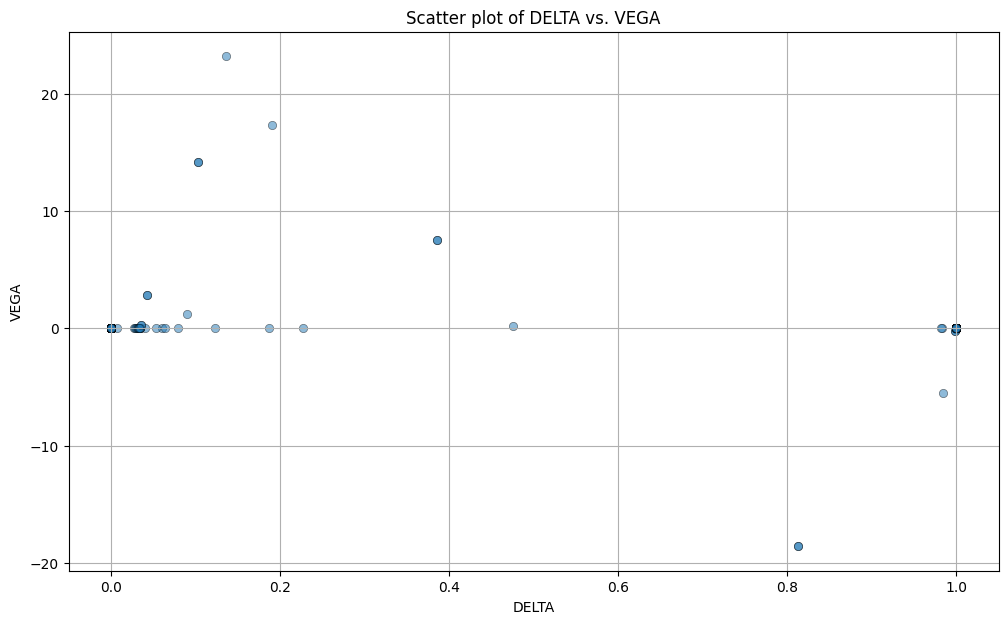

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
final_results_data = pd.read_csv('combined_hedging_metrics_rounded.csv')

# Plotting the scatter plot of DELTA vs. VEGA
plt.figure(figsize=(12, 7))
plt.scatter(final_results_data['DELTA'], final_results_data['VEGA'], alpha=0.5, edgecolors="k", linewidth=0.5)
plt.title('Scatter plot of DELTA vs. VEGA')
plt.xlabel('DELTA')
plt.ylabel('VEGA')
plt.grid(True)
plt.show()

The scatter plot of
Delta vs. Vega provides the following insights:

As delta approaches 0 or 1, the Vega values cluster around zero. Deep in-the-money and far out-of-the-money options tend to have smaller Vegas, indicating they are less sensitive to changes in implied volatility.

For delta values around 0.5 (at-the-money options), there's a spread of vega values. This suggests some variance in sensitivity to implied volatility for these options.

The relationship between delta and vega still doesn't appear to be strictly linear. Although there's a general trend that in-the-money and out-of-the-money options tend to have lower vega values, the relationship isn't one-to-one.

The characteristics of the options and the underlying asset, the market environment during the period covered by the dataset, option moneyness, time to expiration, the current level of implied volatility, and market expectations about future volatility can all influence vega values.

In [ ]:
import pandas as pd
import plotly.express as px

# Load the data
combined_hedging_metrics = pd.read_csv('combined_hedging_metrics_rounded.csv')
profitable_hedges = combined_hedging_metrics[combined_hedging_metrics['Combined_Running_Balance'] > 10000]  # Assuming initial value is 10,000

# Remove rows where DELTA_HEDGE_ROUND is zero for profitable trades
profitable_hedges = profitable_hedges[profitable_hedges['DELTA_HEDGE_ROUND'] != 0]

# Create a new column for the sum of DELTA_HEDGE_ROUND and THETA_HEDGE_ROUND
profitable_hedges['DELTA_PLUS_THETA'] = profitable_hedges['DELTA_HEDGE_ROUND'] + profitable_hedges['THETA_HEDGE_ROUND']

# Count Frequency for DELTA_PLUS_THETA
frequency_delta_theta = profitable_hedges['DELTA_PLUS_THETA'].value_counts().reset_index()
frequency_delta_theta.columns = ['DELTA_PLUS_THETA', 'Frequency']
profitable_hedges = profitable_hedges.merge(frequency_delta_theta, on='DELTA_PLUS_THETA')

# Create Scatter Plot with Hover Data for DELTA_PLUS_THETA
fig1 = px.scatter(profitable_hedges,
                  x='DELTA_PLUS_THETA',
                  y='Frequency',
                  hover_data=['CF_DATE', 'EXPIR_DATE', 'PUTCALLIND', 'STRIKE_PRC', 'CF_CLOSE_x', 'IMP_VOLT', 'CF_CLOSE_y', 'DELTA', 'DELTA_Transaction_Value', 'DELTA_Daily_Buy_Transaction_Cost', 'DELTA_Total_Cost/Revenue', 'Combined_Running_Balance', 'Frequency'])
fig1.update_layout(
    title='Details of DELTA_HEDGE_ROUND + THETA_HEDGE_ROUND for Profitable Trades',
    xaxis_title='DELTA_HEDGE_ROUND + THETA_HEDGE_ROUND Value',
    yaxis_title='Frequency',
    showlegend=False
)
fig1.show()

# Count Frequency for Price_Change
frequency_price = profitable_hedges['Price_Change'].value_counts().reset_index()
frequency_price.columns = ['Price_Change', 'Frequency_Price']
profitable_hedges = profitable_hedges.merge(frequency_price, on='Price_Change')

# Create Scatter Plot with Hover Data for Price_Change
fig2 = px.scatter(profitable_hedges,
                  x='Price_Change',
                  y='Frequency_Price',
                  hover_data=['CF_DATE', 'EXPIR_DATE', 'PUTCALLIND', 'STRIKE_PRC', 'CF_CLOSE_x', 'IMP_VOLT', 'CF_CLOSE_y', 'DELTA', 'DELTA_Transaction_Value', 'DELTA_Daily_Buy_Transaction_Cost', 'DELTA_Total_Cost/Revenue', 'Combined_Running_Balance', 'Frequency_Price'])
fig2.update_layout(
    title='Details of Price_Change for Profitable Trades',
    xaxis_title='Price_Change Value',
    yaxis_title='Frequency',
    showlegend=False
)
fig2.show()


The transaction costs for these theta hedges are high. While profitable in theory, transactions may be challlenging to implement in practice. This code illustrates how removing the theta hedge will reduce costs and impact profit.

In [ ]:
import pandas as pd

# Load the data
final_results_data = pd.read_csv('final_results_fixed_price_rounded.csv')

# Remove the first row to avoid NaN in 'Price_Change' and 'Price_Change_Abs'
final_results_data = final_results_data.iloc[1:].reset_index(drop=True)

# Initialize variables
initial_portfolio_value = 10000.00  # Starting with a portfolio value of $10,000
transaction_cost_per_contract = 0.75  # Transaction cost of $0.75 per contract

# Initialize running balance for combined strategy
combined_running_balance = initial_portfolio_value

# Initialize DataFrame to store metrics for combined strategy
combined_hedging_metrics = pd.DataFrame()

# Loop through each row in the dataset
for index, row in final_results_data.iterrows():
    metrics_row = row.to_dict()  # Start with existing row data
    daily_profit = 0.0  # Initialize daily profit for combined strategy

    # Check profitability for each strategy (excluding THETA) and update running balance if profitable
    for strategy in ['DELTA', 'VEGA', 'GAMMA']:  # Removed 'THETA'
        hedge_col = f"{strategy}_HEDGE_ROUND"
        transaction_value = -1 * row[hedge_col] * row['CF_CLOSE_x']
        daily_buy_transaction_cost = abs(transaction_value) * transaction_cost_per_contract if transaction_value > 0 else 0
        daily_sell_transaction_cost = abs(transaction_value) * transaction_cost_per_contract if transaction_value < 0 else 0
        total_cost_revenue = transaction_value - daily_buy_transaction_cost - daily_sell_transaction_cost

        if total_cost_revenue > 0:  # If the hedge is profitable
            daily_profit += total_cost_revenue  # Add to daily profit
            metrics_row[f"{strategy}_Transaction_Value"] = transaction_value
            metrics_row[f"{strategy}_Daily_Buy_Transaction_Cost"] = daily_buy_transaction_cost
            metrics_row[f"{strategy}_Daily_Sell_Transaction_Cost"] = daily_sell_transaction_cost
            metrics_row[f"{strategy}_Total_Cost/Revenue"] = total_cost_revenue
        else:  # If the hedge is not profitable
            metrics_row[f"{strategy}_Transaction_Value"] = 0
            metrics_row[f"{strategy}_Daily_Buy_Transaction_Cost"] = 0
            metrics_row[f"{strategy}_Daily_Sell_Transaction_Cost"] = 0
            metrics_row[f"{strategy}_Total_Cost/Revenue"] = 0

    # Update the running balance for the combined strategy
    combined_running_balance += daily_profit
    metrics_row["Combined_Running_Balance"] = combined_running_balance

    # Append metrics for this row to the combined DataFrame
    combined_hedging_metrics = pd.concat([combined_hedging_metrics, pd.DataFrame([metrics_row])], ignore_index=True)

# Drop all THETA-related columns
combined_hedging_metrics = combined_hedging_metrics.drop(columns=[col for col in combined_hedging_metrics.columns if 'THETA' in col])

# Save the modified DataFrame to a new CSV file
csv_file_path = 'combined_hedging_metrics_without_theta_rounded.csv'
combined_hedging_metrics.to_csv(csv_file_path, index=False)

csv_file_path, combined_hedging_metrics


('combined_hedging_metrics_without_theta_rounded.csv',
      Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
 0           374  /GDAX180000R0.EX  2019-07-18  2020-06-19       PUT    
 1           332  /GDAX142500R0.EX  2019-11-20  2020-06-19       PUT    
 2           358  /GDAX149000R0.EX  2020-01-15  2020-06-19       PUT    
 3           348  /GDAX146500R0.EX  2020-01-20  2020-06-19       PUT    
 4           367  /GDAX165000F0.EX  2020-02-12  2020-06-19       CALL   
 ..          ...               ...         ...         ...        ...   
 372         154   /GDAX98000R0.EX  2020-05-15  2020-06-19       PUT    
 373         152   /GDAX97500R0.EX  2020-05-15  2020-06-19       PUT    
 374         151   /GDAX97500F0.EX  2020-05-15  2020-06-19       CALL   
 375         165  /GDAX101000F0.EX  2020-05-15  2020-06-19       CALL   
 376           1   /GDAX20000F0.EX  2020-05-15  2020-06-19       CALL   
 
      STRIKE_PRC  CF_CLOSE_x  IMP_VOLT  CF_CLOSE_y     DELTA  ...  

In [ ]:
combined_hedging_metrics_without_theta = pd.read_csv('combined_hedging_metrics_without_theta_rounded.csv')

# Print the final value in the "Combined Running Balance" column
final_combined_running_balance = combined_hedging_metrics_without_theta["Combined_Running_Balance"].iloc[-1]
print(f"Final Combined Running Balance: ${final_combined_running_balance:.2f}")

Final Combined Running Balance: $1648895.77


In [ ]:
import pandas as pd
import plotly.express as px

# Load the data
combined_hedging_metrics = pd.read_csv('combined_hedging_metrics_without_theta_rounded.csv')

# Exclude rows where DELTA_HEDGE_ROUND is 0
combined_hedging_metrics = combined_hedging_metrics[combined_hedging_metrics['DELTA_HEDGE_ROUND'] != 0]

# Step 1: Count Frequency for DELTA_HEDGE_ROUND
frequency_delta = combined_hedging_metrics['DELTA_HEDGE_ROUND'].value_counts().reset_index()
frequency_delta.columns = ['DELTA_HEDGE_ROUND', 'Frequency_Delta']
combined_hedging_metrics = combined_hedging_metrics.merge(frequency_delta, on='DELTA_HEDGE_ROUND', how='left')

# Step 2: Create Scatter Plot with Hover Data for DELTA_HEDGE_ROUND
fig1 = px.scatter(combined_hedging_metrics,
                  x='DELTA_HEDGE_ROUND',
                  y='Frequency_Delta',
                  hover_data=['CF_DATE', 'EXPIR_DATE', 'PUTCALLIND', 'STRIKE_PRC', 'CF_CLOSE_x', 'IMP_VOLT', 'CF_CLOSE_y', 'DELTA', 'DELTA_Transaction_Value', 'DELTA_Daily_Buy_Transaction_Cost', 'DELTA_Total_Cost/Revenue', 'Combined_Running_Balance', 'Frequency_Delta'])
fig1.update_layout(
    title='Details of DELTA_HEDGE_ROUND',
    xaxis_title='DELTA_HEDGE_ROUND Value',
    yaxis_title='Frequency',
    showlegend=False
)
fig1.show()

# Step 3: Count Frequency for Price_Change
frequency_price = combined_hedging_metrics['Price_Change'].value_counts().reset_index()
frequency_price.columns = ['Price_Change', 'Frequency_Price']
combined_hedging_metrics = combined_hedging_metrics.merge(frequency_price, on='Price_Change', how='left')

# Step 4: Create Scatter Plot with Hover Data for Price_Change
fig2 = px.scatter(combined_hedging_metrics,
                  x='Price_Change',
                  y='Frequency_Price',
                  hover_data=['CF_DATE', 'EXPIR_DATE', 'PUTCALLIND', 'STRIKE_PRC', 'CF_CLOSE_x', 'IMP_VOLT', 'CF_CLOSE_y', 'DELTA', 'DELTA_Transaction_Value', 'DELTA_Daily_Buy_Transaction_Cost', 'DELTA_Total_Cost/Revenue', 'Combined_Running_Balance', 'Frequency_Price'])
fig2.update_layout(
    title='Details of Price_Change',
    xaxis_title='Price_Change Value',
    yaxis_title='Frequency',
    showlegend=False
)
fig2.show()


1. **Price Change Distribution for Profitable Trades**:
    - Profitable trades spanned a spectrum of price changes, from slight to substantial. This observation accentuates that the hedging strategy in place is versatile, capable of generating profits across diverse market conditions.

2. **Delta Hedge Distribution for Profitable Trades**:
    - The scatter plot for `DELTA_HEDGE_ROUND` displays a broad distribution, emphasizing that profitable outcomes were realized across an array of delta hedge values.
    - Most of the profitable hedges did not revolve around a neutral delta (i.e., a delta value close to zero). Instead, they often reflected distinct bullish or bearish positions. This suggests that the implemented strategy frequently positioned itself in anticipation of a directional price movement—either upward or downward.

3. **Delta and Theta Combination**:
    - Combining the effects of delta and theta hedges (`DELTA_PLUS_THETA`), the strategy frequently leveraged both time decay (theta) and price movement (delta) to maximize profitability. The distribution of `DELTA_PLUS_THETA` further reinforces the notion that the strategy was not static but rather adapted to the evolving dynamics of the market.

**Key Takeaways**:

- The broad range of price changes encompassed by profitable trades underscores the adaptability and robustness of the hedging strategy.

- The hedging strategy, in theory, anticipates the directional movement of the underlying asset. This is evident from the array of `DELTA_HEDGE_ROUND` values, which often veered away from neutrality.

In conclusion, the hedging strategy balances multiple elements of options trading—directional movement through delta and the benefits of time decay through theta. This multifaceted approach allows it to thrive across various market scenarios.

In [ ]:
import pandas as pd

# Load the data
combined_hedging_metrics_rounded = pd.read_csv('combined_hedging_metrics_rounded.csv')
combined_hedging_metrics_without_theta_rounded = pd.read_csv('combined_hedging_metrics_without_theta_rounded.csv')

# Extract the final 'Combined_Running_Balance' value for each strategy and store them in a dictionary
balances = {
    "Delta, Vega, Theta, Gamma Rounded": combined_hedging_metrics_rounded['Combined_Running_Balance'].iloc[-1],
    "Delta, Vega, Gamma Rounded": combined_hedging_metrics_without_theta_rounded['Combined_Running_Balance'].iloc[-1],
}

# Sort the dictionary by value in descending order
sorted_balances = dict(sorted(balances.items(), key=lambda item: item[1], reverse=True))

# Print the sorted balances
for strategy, balance in sorted_balances.items():
    print(f"{strategy}: ${balance:.2f}")


Delta, Vega, Theta, Gamma Rounded: $82606287.10
Delta, Vega, Gamma Rounded: $1648895.77


In [ ]:
import plotly.graph_objects as go
import pandas as pd

# Load the data
combined_hedging_metrics_rounded = pd.read_csv('combined_hedging_metrics_rounded.csv')
combined_hedging_metrics_without_theta_rounded = pd.read_csv('combined_hedging_metrics_without_theta_rounded.csv')

# Create the enhanced figure with improved hover behavior
enhanced_hover_fig = go.Figure()

# Customize the hover template and set unified hover information
hover_template = '<b>%{fullData.name}</b><br>Time: %{x}<br>Balance: %{y:$,.2f}'

# Add traces for each strategy combination with custom hovertemplate

enhanced_hover_fig.add_trace(go.Scatter(x=combined_hedging_metrics_rounded.index,
                                        y=combined_hedging_metrics_rounded['Combined_Running_Balance'],
                                        mode='lines',
                                        name='Delta, Vega, Theta Gamma, Rounded',
                                        line=dict(dash='dash', width=2),
                                        hovertemplate=hover_template))

enhanced_hover_fig.add_trace(go.Scatter(x=combined_hedging_metrics_without_theta_rounded.index,
                                        y=combined_hedging_metrics_without_theta_rounded['Combined_Running_Balance'],
                                        mode='lines',
                                        name='Delta, Vega, Gamma Rounded',
                                        line=dict(dash='dot', width=2),
                                        hovertemplate=hover_template))

# Customize the layout
enhanced_hover_fig.update_layout(title='Influence of Different Greeks on Combined Running Balance',
                                 xaxis_title='Time',
                                 yaxis_title='Combined Running Balance',
                                 template="plotly",
                                 legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
                                 hovermode='x unified')

# Ensure the y-axis starts at zero
enhanced_hover_fig.update_yaxes(rangemode="tozero")

enhanced_hover_fig.show()


In [ ]:
import pandas as pd

# Load the data
final_results_data = pd.read_csv('final_results_fixed_price_rounded.csv')

# Remove the first row to avoid NaN in 'Price_Change' and 'Price_Change_Abs'
final_results_data = final_results_data.iloc[1:].reset_index(drop=True)

# Initialize variables
initial_portfolio_value = 10000.00  # Starting with a portfolio value of $10,000
transaction_cost_per_contract = 0.75  # Transaction cost of $0.75 per contract

# Initialize running balance for portfolio-based combined strategy
portfolio_running_balance = initial_portfolio_value

# Initialize DataFrame to store metrics for portfolio-based combined strategy
portfolio_hedging_metrics = pd.DataFrame()

# Initialize overall portfolio Greeks to zero
overall_portfolio_delta = 0.0
overall_portfolio_vega = 0.0
overall_portfolio_theta = 0.0
overall_portfolio_gamma = 0.0

# Loop through each row in the dataset
for index, row in final_results_data.iterrows():
    # Initialize daily profit and daily changes in Greeks
    daily_profit = 0.0
    daily_delta_change = 0.0
    daily_vega_change = 0.0
    daily_theta_change = 0.0
    daily_gamma_change = 0.0

    # Calculate overall portfolio Greeks based on the current option
    overall_portfolio_delta += row['DELTA']
    overall_portfolio_vega += row['VEGA']
    overall_portfolio_theta += row['THETA']
    overall_portfolio_gamma += row['GAMMA']

    # Store metrics for this option
    metrics_row = {
        "Overall_Portfolio_Delta": overall_portfolio_delta,
        "Overall_Portfolio_Vega": overall_portfolio_vega,
        "Overall_Portfolio_Theta": overall_portfolio_theta,
        "Overall_Portfolio_Gamma": overall_portfolio_gamma,
    }

    # Check profitability for each strategy and update running balance if profitable
    for strategy in ['DELTA', 'VEGA', 'THETA', 'GAMMA']:
        hedge_col = f"{strategy}_HEDGE_ROUND"
        transaction_value = -1 * row[hedge_col] * row['CF_CLOSE_x']
        daily_buy_transaction_cost = abs(transaction_value) * transaction_cost_per_contract if transaction_value > 0 else 0
        daily_sell_transaction_cost = abs(transaction_value) * transaction_cost_per_contract if transaction_value < 0 else 0
        total_cost_revenue = transaction_value - daily_buy_transaction_cost - daily_sell_transaction_cost

        if total_cost_revenue > 0:  # If the hedge is profitable
            daily_profit += total_cost_revenue  # Add to daily profit

    # Update the running balance for the portfolio-based strategy
    portfolio_running_balance += daily_profit
    metrics_row["Portfolio_Running_Balance"] = portfolio_running_balance

    # Append metrics for this row to the portfolio DataFrame
    portfolio_hedging_metrics = pd.concat([portfolio_hedging_metrics, pd.DataFrame([metrics_row])], ignore_index=True)

# Save the DataFrame to a new CSV file
portfolio_hedging_metrics.to_csv('portfolio_hedging_metrics_rounded.csv', index=False)

portfolio_hedging_metrics.head()


,Overall_Portfolio_Delta,Overall_Portfolio_Vega,Overall_Portfolio_Theta,Overall_Portfolio_Gamma,Portfolio_Running_Balance
0,0.000000,0.000000,0.000000,0.000000e+00,1.000000e+04
1,0.079458,0.000002,-55.345439,2.814464e-07,5.067707e+07
2,0.086698,0.000002,-55.345439,6.413559e-07,5.067707e+07
3,0.147313,0.000714,-110.775882,-6.294960e-07,5.768594e+07
4,0.147313,0.000714,-110.775882,-6.294960e-07,5.768594e+07


**Shadow Delta:**
In the ideal Black-Scholes world, delta is the rate of change of the option price with respect to changes in the underlying asset's price. Practically speaking, it represents the number of units of the underlying you would need to hold (or short) to be neutral to small changes in the price of the underlying.

However, in the real world, there are many factors at play. The actual delta that traders might use to hedge their options can differ from the theoretical delta provided by the Black-Scholes or any other model. This "real-world" delta that traders use in practice, taking into account market frictions, imperfections, and other factors, is what Nassim Taleb refers to as the "shadow delta."

The shadow delta might incorporate adjustments for:

* Discrete hedging (as opposed to continuous hedging assumed in the Black-Scholes model)

* Transaction costs

* The impact of jumps or gapped movements in the underlying price

* The trader's anticipations about future volatility or major market moves

* Other market imperfections and realities that aren't captured in the theoretical model

In essence, while the Black-Scholes delta is a theoretical construct, the shadow delta is a practical, real-world tool that traders might use. It's a manifestation of the difference between the sanitized world of academic finance and the messiness of real-world trading.

In [ ]:
import pandas as pd

# Load the data
final_results_data = pd.read_csv('final_results_fixed_price.csv')

# Remove the first row to avoid NaN in 'Price_Change' and 'Price_Change_Abs'
final_results_data = final_results_data.iloc[1:].reset_index(drop=True)

# Initialize variables
initial_portfolio_value = 10000.00  # Starting with a portfolio value of $10,000
transaction_cost_per_contract = 0.75  # Transaction cost of $0.75 per contract

# Initialize running balance for combined strategy
combined_running_balance = initial_portfolio_value

# Initialize DataFrame to store metrics for combined strategy
combined_hedging_metrics = pd.DataFrame()

# Loop through each row in the dataset
for index, row in final_results_data.iterrows():
    metrics_row = row.to_dict()  # Start with existing row data
    daily_profit = 0.0  # Initialize daily profit for combined strategy

    # Check profitability for each strategy and update running balance if profitable
    for strategy in ['DELTA', 'VEGA', 'THETA', 'GAMMA']:
        hedge_col = f"{strategy}_HEDGE"
        transaction_value = -1 * row[hedge_col] * row['CF_CLOSE_x']
        daily_buy_transaction_cost = abs(transaction_value) * transaction_cost_per_contract if transaction_value > 0 else 0
        daily_sell_transaction_cost = abs(transaction_value) * transaction_cost_per_contract if transaction_value < 0 else 0
        total_cost_revenue = transaction_value - daily_buy_transaction_cost - daily_sell_transaction_cost

        if total_cost_revenue > 0:  # If the hedge is profitable
            daily_profit += total_cost_revenue  # Add to daily profit
            metrics_row[f"{strategy}_Transaction_Value"] = transaction_value
            metrics_row[f"{strategy}_Daily_Buy_Transaction_Cost"] = daily_buy_transaction_cost
            metrics_row[f"{strategy}_Daily_Sell_Transaction_Cost"] = daily_sell_transaction_cost
            metrics_row[f"{strategy}_Total_Cost/Revenue"] = total_cost_revenue
        else:  # If the hedge is not profitable
            metrics_row[f"{strategy}_Transaction_Value"] = 0
            metrics_row[f"{strategy}_Daily_Buy_Transaction_Cost"] = 0
            metrics_row[f"{strategy}_Daily_Sell_Transaction_Cost"] = 0
            metrics_row[f"{strategy}_Total_Cost/Revenue"] = 0

    # Update the running balance for the combined strategy
    combined_running_balance += daily_profit
    metrics_row["Combined_Running_Balance"] = combined_running_balance

    # Append metrics for this row to the combined DataFrame
    combined_hedging_metrics = pd.concat([combined_hedging_metrics, pd.DataFrame([metrics_row])], ignore_index=True)

# Save the DataFrame to a new CSV file
combined_hedging_metrics.to_csv('combined_hedging_metrics.csv', index=False)


In [ ]:
import pandas as pd

# Load the data
final_results_data = pd.read_csv('final_results_fixed_price.csv')
combined_hedging_metrics = pd.read_csv('combined_hedging_metrics.csv')

# Calculate the volatility change
final_results_data['Volatility_Change'] = final_results_data['IMP_VOLT'].diff()
final_results_data['Volatility_Change'].fillna(0, inplace=True)

# Initialize variables
initial_portfolio_value = 10000.00  # Starting with a portfolio value of $10,000
transaction_cost_per_contract = 0.75  # Transaction cost of $0.75 per contract

# Initialize running balance for combined strategy
combined_running_balance = initial_portfolio_value

# Compute shadow delta and related metrics using matching 'Unnamed: 0' values
for index, row in final_results_data.iterrows():
    # Extract hedges from the combined_hedging_metrics data using matching 'Unnamed: 0' values
    matching_rows = combined_hedging_metrics[combined_hedging_metrics['Unnamed: 0'] == row['Unnamed: 0']]

    # If there are no matching rows, skip this iteration
    if matching_rows.empty:
        continue

    # If there are matching rows, take the first one
    matching_row = matching_rows.iloc[0]

    delta_hedge = matching_row['DELTA_HEDGE']
    gamma_hedge = matching_row['GAMMA_HEDGE']
    vega_hedge = matching_row['VEGA_HEDGE']

    # Compute shadow delta and round it
    shadow_delta = round(delta_hedge + gamma_hedge * row['Price_Change'] + vega_hedge * row['Volatility_Change'])

    # Update shadow delta metrics in final_results_data
    final_results_data.at[index, 'SHADOW_DELTA'] = shadow_delta
    transaction_value = -1 * shadow_delta * row['CF_CLOSE_x']
    final_results_data.at[index, 'Shadow_Delta_Transaction_Value'] = transaction_value
    daily_buy_transaction_cost = abs(transaction_value) * transaction_cost_per_contract if transaction_value > 0 else 0
    final_results_data.at[index, 'Shadow_Delta_Daily_Buy_Transaction_Cost'] = daily_buy_transaction_cost
    daily_sell_transaction_cost = abs(transaction_value) * transaction_cost_per_contract if transaction_value < 0 else 0
    final_results_data.at[index, 'Shadow_Delta_Daily_Sell_Transaction_Cost'] = daily_sell_transaction_cost
    total_cost_revenue = transaction_value - daily_buy_transaction_cost - daily_sell_transaction_cost
    final_results_data.at[index, 'Shadow_Delta_Total_Cost/Revenue'] = total_cost_revenue

    # Update the running balance for shadow delta strategy only if the hedge is profitable
    if total_cost_revenue > 0:
        combined_running_balance += total_cost_revenue
    final_results_data.at[index, "Shadow_Delta_Combined_Running_Balance"] = combined_running_balance

# Save the refined dataset
final_results_data.to_csv('shadow_delta_metrics_refined_profit_rounded.csv', index=False)


In [ ]:
final_shadow_delta_running_balance = pd.read_csv('shadow_delta_metrics_refined_profit_rounded.csv')

final_balance = final_shadow_delta_running_balance["Shadow_Delta_Combined_Running_Balance"].iloc[-1]

print(f"Final Shadow Delta Running Balance: ${final_balance:.2f}")

Final Shadow Delta Running Balance: $1653544.98


In [ ]:
import pandas as pd
import plotly.express as px

# Load the refined dataset
final_results_data = pd.read_csv('shadow_delta_metrics_refined_profit_rounded.csv')

# Exclude rows where SHADOW_DELTA is close to 0 (for a better visualization)
final_results_data = final_results_data[abs(final_results_data['SHADOW_DELTA']) > 0.01]

# Step 1: Count Frequency for SHADOW_DELTA
frequency_shadow_delta = final_results_data['SHADOW_DELTA'].value_counts().reset_index()
frequency_shadow_delta.columns = ['SHADOW_DELTA', 'Frequency_Shadow_Delta']
final_results_data = final_results_data.merge(frequency_shadow_delta, on='SHADOW_DELTA', how='left')

# Create Scatter Plot with Hover Data for SHADOW_DELTA
fig1 = px.scatter(final_results_data,
                  x='SHADOW_DELTA',
                  y='Frequency_Shadow_Delta',
                  hover_data=['CF_DATE', 'EXPIR_DATE', 'PUTCALLIND', 'STRIKE_PRC', 'CF_CLOSE_x', 'IMP_VOLT', 'CF_CLOSE_y', 'Shadow_Delta_Transaction_Value', 'Shadow_Delta_Daily_Buy_Transaction_Cost', 'Shadow_Delta_Total_Cost/Revenue', 'Shadow_Delta_Combined_Running_Balance', 'Frequency_Shadow_Delta'])
fig1.update_layout(
    title='Details of SHADOW_DELTA',
    xaxis_title='SHADOW_DELTA Value',
    yaxis_title='Frequency',
    showlegend=False
)
fig1.show()

# Step 2: Count Frequency for Price_Change
frequency_price = final_results_data['Price_Change'].value_counts().reset_index()
frequency_price.columns = ['Price_Change', 'Frequency_Price']
final_results_data = final_results_data.merge(frequency_price, on='Price_Change', how='left')

# Create Scatter Plot with Hover Data for Price_Change
fig2 = px.scatter(final_results_data,
                  x='Price_Change',
                  y='Frequency_Price',
                  hover_data=['CF_DATE', 'EXPIR_DATE', 'PUTCALLIND', 'STRIKE_PRC', 'CF_CLOSE_x', 'IMP_VOLT', 'CF_CLOSE_y', 'Shadow_Delta_Transaction_Value', 'Shadow_Delta_Daily_Buy_Transaction_Cost', 'Shadow_Delta_Total_Cost/Revenue', 'Shadow_Delta_Combined_Running_Balance', 'Frequency_Price'])
fig2.update_layout(
    title='Details of Price_Change',
    xaxis_title='Price_Change Value',
    yaxis_title='Frequency',
    showlegend=False
)
fig2.show()


**Key Takeaways:**

Understanding the distribution of SHADOW_DELTA can provide insights into the strategy's risk appetite. A wide distribution suggests the strategy frequently took strong positions, anticipating major price movements.

The dataset likely captures diverse market conditions, as indicated by the range of Price_Change values.

By observing the relationship between Price_Change and SHADOW_DELTA, one can gain insights into how well the strategy anticipated market movements.

In [ ]:
import pandas as pd
import plotly.graph_objects as go

# Load the datasets
refined_profit_data = pd.read_csv('shadow_delta_metrics_refined_profit_rounded.csv')

# Filter data to keep only profitable rows
refined_profit_data = refined_profit_data[refined_profit_data['Shadow_Delta_Total_Cost/Revenue'] > 0]

# Define a function to create boxplots for a given metric using plotly
def create_boxplot_plotly(metric):
    fig = go.Figure()

    # Box plot for Refined Profit Strategy
    fig.add_trace(go.Box(
        y=refined_profit_data[metric],
        name='Refined Profit Strategy',
        boxpoints='all',  # Display the original data points
        jitter=0.3,
        marker=dict(color='blue')
    ))

    # Update layout
    fig.update_layout(title=f'Boxplot of {metric} for Profitable Strategies',
                      yaxis_title=metric,
                      boxmode='group')

    fig.show()

# Plot box plots for the key metrics
for metric in ['Price_Change', 'Volatility_Change', 'DELTA_HEDGE', 'GAMMA_HEDGE', 'VEGA_HEDGE']:
    create_boxplot_plotly(metric)


**Theta Hedge Inclusion:** The theta hedge value, which accounts for the rate of change in an option's price given a one-day change in its time to expiration, is now incorporated into the shadow delta calculation.

In [ ]:
import pandas as pd

# Load the data
final_results_data = pd.read_csv('final_results_fixed_price.csv')
combined_hedging_metrics = pd.read_csv('combined_hedging_metrics.csv')

# Calculate the volatility change
final_results_data['Volatility_Change'] = final_results_data['IMP_VOLT'].diff()
final_results_data['Volatility_Change'].fillna(0, inplace=True)

# Initialize variables
initial_portfolio_value = 10000.00  # Starting with a portfolio value of $10,000
transaction_cost_per_contract = 0.75  # Transaction cost of $0.75 per contract

# Initialize running balance for combined strategy
combined_running_balance = initial_portfolio_value

# Compute shadow delta and related metrics using matching 'Unnamed: 0' values
for index, row in final_results_data.iterrows():
    # Extract hedges from the combined_hedging_metrics data using matching 'Unnamed: 0' values
    matching_rows = combined_hedging_metrics[combined_hedging_metrics['Unnamed: 0'] == row['Unnamed: 0']]

    # If there are no matching rows, skip this iteration
    if matching_rows.empty:
        continue

    # If there are matching rows, take the first one
    matching_row = matching_rows.iloc[0]

    delta_hedge = matching_row['DELTA_HEDGE']
    gamma_hedge = matching_row['GAMMA_HEDGE']
    vega_hedge = matching_row['VEGA_HEDGE']
    theta_hedge = matching_row['THETA_HEDGE']  # Extracting THETA_HEDGE

    # Compute shadow delta including THETA_HEDGE and round it
    shadow_delta = round(delta_hedge + gamma_hedge * row['Price_Change'] + vega_hedge * row['Volatility_Change'] + theta_hedge)

    # Update shadow delta metrics in final_results_data
    final_results_data.at[index, 'SHADOW_DELTA'] = shadow_delta
    transaction_value = -1 * shadow_delta * row['CF_CLOSE_x']
    final_results_data.at[index, 'Shadow_Delta_Transaction_Value'] = transaction_value
    daily_buy_transaction_cost = abs(transaction_value) * transaction_cost_per_contract if transaction_value > 0 else 0
    final_results_data.at[index, 'Shadow_Delta_Daily_Buy_Transaction_Cost'] = daily_buy_transaction_cost
    daily_sell_transaction_cost = abs(transaction_value) * transaction_cost_per_contract if transaction_value < 0 else 0
    final_results_data.at[index, 'Shadow_Delta_Daily_Sell_Transaction_Cost'] = daily_sell_transaction_cost
    total_cost_revenue = transaction_value - daily_buy_transaction_cost - daily_sell_transaction_cost
    final_results_data.at[index, 'Shadow_Delta_Total_Cost/Revenue'] = total_cost_revenue

    # Update the running balance for shadow delta strategy only if the hedge is profitable
    if total_cost_revenue > 0:
        combined_running_balance += total_cost_revenue
    final_results_data.at[index, "Shadow_Delta_Combined_Running_Balance"] = combined_running_balance

# Save the refined dataset
final_results_data.to_csv('shadow_delta_metrics_refined_profit_theta_rounded.csv', index=False)


In [ ]:
final_shadow_delta_running_balance = pd.read_csv('shadow_delta_metrics_refined_profit_theta_rounded.csv')

final_balance = final_shadow_delta_running_balance["Shadow_Delta_Combined_Running_Balance"].iloc[-1]

print(f"Final Shadow Delta Running Balance: ${final_balance:.2f}")

Final Shadow Delta Running Balance: $82482340.80


In [ ]:
import pandas as pd
import plotly.express as px

# Load the refined dataset
final_results_data = pd.read_csv('shadow_delta_metrics_refined_profit_theta_rounded.csv')

# Exclude rows where SHADOW_DELTA is close to 0 (for a better visualization)
final_results_data = final_results_data[abs(final_results_data['SHADOW_DELTA']) > 0.01]

# Step 1: Count Frequency for SHADOW_DELTA
frequency_shadow_delta = final_results_data['SHADOW_DELTA'].value_counts().reset_index()
frequency_shadow_delta.columns = ['SHADOW_DELTA', 'Frequency_Shadow_Delta']
final_results_data = final_results_data.merge(frequency_shadow_delta, on='SHADOW_DELTA', how='left')

# Create Scatter Plot with Hover Data for SHADOW_DELTA
fig1 = px.scatter(final_results_data,
                  x='SHADOW_DELTA',
                  y='Frequency_Shadow_Delta',
                  hover_data=['CF_DATE', 'EXPIR_DATE', 'PUTCALLIND', 'STRIKE_PRC', 'CF_CLOSE_x', 'IMP_VOLT', 'CF_CLOSE_y', 'Shadow_Delta_Transaction_Value', 'Shadow_Delta_Daily_Buy_Transaction_Cost', 'Shadow_Delta_Total_Cost/Revenue', 'Shadow_Delta_Combined_Running_Balance', 'Frequency_Shadow_Delta'])
fig1.update_layout(
    title='Details of SHADOW_DELTA',
    xaxis_title='SHADOW_DELTA Value',
    yaxis_title='Frequency',
    showlegend=False
)
fig1.show()

# Step 2: Count Frequency for Price_Change
frequency_price = final_results_data['Price_Change'].value_counts().reset_index()
frequency_price.columns = ['Price_Change', 'Frequency_Price']
final_results_data = final_results_data.merge(frequency_price, on='Price_Change', how='left')

# Create Scatter Plot with Hover Data for Price_Change
fig2 = px.scatter(final_results_data,
                  x='Price_Change',
                  y='Frequency_Price',
                  hover_data=['CF_DATE', 'EXPIR_DATE', 'PUTCALLIND', 'STRIKE_PRC', 'CF_CLOSE_x', 'IMP_VOLT', 'CF_CLOSE_y', 'Shadow_Delta_Transaction_Value', 'Shadow_Delta_Daily_Buy_Transaction_Cost', 'Shadow_Delta_Total_Cost/Revenue', 'Shadow_Delta_Combined_Running_Balance', 'Frequency_Price'])
fig2.update_layout(
    title='Details of Price_Change',
    xaxis_title='Price_Change Value',
    yaxis_title='Frequency',
    showlegend=False
)
fig2.show()


In [ ]:
import pandas as pd
import plotly.graph_objects as go

# Load the datasets
refined_profit_data = pd.read_csv('shadow_delta_metrics_refined_profit_theta_rounded.csv')

# Filter data to keep only profitable rows
refined_profit_data = refined_profit_data[refined_profit_data['Shadow_Delta_Total_Cost/Revenue'] > 0]

# Define a function to create boxplots for a given metric using plotly
def create_boxplot_plotly(metric):
    fig = go.Figure()

    # Box plot for Refined Profit Strategy
    fig.add_trace(go.Box(
        y=refined_profit_data[metric],
        name='Refined Profit Strategy',
        boxpoints='all',  # Display the original data points
        jitter=0.3,
        marker=dict(color='blue')
    ))

    # Update layout
    fig.update_layout(title=f'Boxplot of {metric} for Profitable Strategies',
                      yaxis_title=metric,
                      boxmode='group')

    fig.show()

# Plot box plots for the key metrics
for metric in ['Price_Change', 'Volatility_Change', 'DELTA_HEDGE', 'GAMMA_HEDGE', 'VEGA_HEDGE']:
    create_boxplot_plotly(metric)


**Delta Adjustment Based on Volatility Smile:** The delta is adjusted based on whether the option is in-the-money or out-of-the-money, and if it's a call or put. This adjustment aims to account for the curvature (smile) seen in volatility as a function of the option's strike price.

In [ ]:
import pandas as pd

# Load the data
final_results_data = pd.read_csv('final_results_fixed_price.csv')
combined_hedging_metrics = pd.read_csv('combined_hedging_metrics.csv')

# Calculate the volatility change
final_results_data['Volatility_Change'] = final_results_data['IMP_VOLT'].diff()
final_results_data['Volatility_Change'].fillna(0, inplace=True)

# Initialize variables
initial_portfolio_value = 10000.00  # Starting with a portfolio value of $10,000
transaction_cost_per_contract = 0.75  # Transaction cost of $0.75 per contract
adjustment_factor = 0.05  # Factor to adjust the delta based on the volatility smile

# Initialize running balance for combined strategy
adjusted_running_balance = initial_portfolio_value

# Compute reversed shadow delta with delta adjustment and related metrics using matching 'Unnamed: 0' values
for index, row in final_results_data.iterrows():
    # Extract hedges from the combined_hedging_metrics data using matching 'Unnamed: 0' values
    matching_rows = combined_hedging_metrics[combined_hedging_metrics['Unnamed: 0'] == row['Unnamed: 0']]

    # If there are no matching rows, skip this iteration
    if matching_rows.empty:
        continue

    # If there are matching rows, take the first one
    matching_row = matching_rows.iloc[0]

    delta_hedge = matching_row['DELTA_HEDGE']
    gamma_hedge = matching_row['GAMMA_HEDGE']
    vega_hedge = matching_row['VEGA_HEDGE']

    # Calculate the difference between the stock price and the strike price
    price_diff = row['CF_CLOSE_y'] - matching_row['STRIKE_PRC']

    # Adjust delta based on the volatility smile
    if matching_row['PUTCALLIND'] == 'CALL':  # For call options
        if price_diff > 0:  # In-the-money
            delta_hedge -= adjustment_factor * abs(price_diff)
        else:  # Out-of-the-money
            delta_hedge += adjustment_factor * abs(price_diff)
    else:  # For put options
        if price_diff < 0:  # In-the-money
            delta_hedge += adjustment_factor * abs(price_diff)
        else:  # Out-of-the-money
            delta_hedge -= adjustment_factor * abs(price_diff)

    # Compute and round shadow delta
    shadow_delta_adjusted = round(delta_hedge + gamma_hedge * row['Price_Change'] + vega_hedge * row['Volatility_Change'])

    # Update shadow delta metrics in final_results_data
    final_results_data.at[index, 'SHADOW_DELTA_ADJUSTED'] = shadow_delta_adjusted
    transaction_value = -1 * shadow_delta_adjusted * row['CF_CLOSE_x']
    final_results_data.at[index, 'Shadow_Delta_Adjusted_Transaction_Value'] = transaction_value
    daily_buy_transaction_cost = abs(transaction_value) * transaction_cost_per_contract if transaction_value > 0 else 0
    final_results_data.at[index, 'Shadow_Delta_Adjusted_Daily_Buy_Transaction_Cost'] = daily_buy_transaction_cost
    daily_sell_transaction_cost = abs(transaction_value) * transaction_cost_per_contract if transaction_value < 0 else 0
    final_results_data.at[index, 'Shadow_Delta_Adjusted_Daily_Sell_Transaction_Cost'] = daily_sell_transaction_cost
    total_cost_revenue = transaction_value - daily_buy_transaction_cost - daily_sell_transaction_cost
    final_results_data.at[index, 'Shadow_Delta_Adjusted_Total_Cost/Revenue'] = total_cost_revenue

    # Update the adjusted running balance only if the hedge is profitable
    if total_cost_revenue > 0:
        adjusted_running_balance += total_cost_revenue
    final_results_data.at[index, "Adjusted_Shadow_Delta_Combined_Running_Balance"] = adjusted_running_balance

# Save the refined dataset
final_results_data.to_csv('shadow_delta_metrics_smile_adjusted_rounded.csv', index=False)


In [ ]:
import pandas as pd
import plotly.graph_objects as go

# Load the refined dataset
shadow_delta_data = pd.read_csv('shadow_delta_metrics_smile_adjusted_rounded.csv')

# Filter data to keep only profitable rows
shadow_delta_data = shadow_delta_data[shadow_delta_data['Shadow_Delta_Adjusted_Total_Cost/Revenue'] > 0]

def create_boxplot_for_shadow_delta(metric):
    fig = go.Figure()

    # Box plot for Shadow Delta Adjusted
    fig.add_trace(go.Box(
        y=shadow_delta_data[metric],
        name='Shadow Delta Adjusted',
        boxpoints='all',  # Display the original data points
        jitter=0.3,
        marker=dict(color='blue')
    ))

    # Update layout
    fig.update_layout(title=f'Boxplot of {metric} for Profitable Trades with Delta Adjusted',
                      yaxis_title=metric,
                      boxmode='group')

    fig.show()

# Plot box plot for the SHADOW_DELTA_ADJUSTED metric
create_boxplot_for_shadow_delta('SHADOW_DELTA_ADJUSTED')


**Theta Hedge Inclusion:** The theta hedge value, which accounts for the rate of change in an option's price given a one-day change in its time to expiration, is now incorporated into the adjusted shadow delta calculation.

In [ ]:
import pandas as pd

# Load the data
final_results_data = pd.read_csv('final_results_fixed_price.csv')
combined_hedging_metrics = pd.read_csv('combined_hedging_metrics.csv')

# Calculate the volatility change
final_results_data['Volatility_Change'] = final_results_data['IMP_VOLT'].diff()
final_results_data['Volatility_Change'].fillna(0, inplace=True)

# Initialize variables
initial_portfolio_value = 10000.00  # Starting with a portfolio value of $10,000
transaction_cost_per_contract = 0.75  # Transaction cost of $0.75 per contract
adjustment_factor = 0.05  # Factor to adjust the delta based on the volatility smile

# Initialize running balance for combined strategy
adjusted_running_balance = initial_portfolio_value

# Compute reversed shadow delta with delta adjustment and related metrics using matching 'Unnamed: 0' values
for index, row in final_results_data.iterrows():
    # Extract hedges from the combined_hedging_metrics data using matching 'Unnamed: 0' values
    matching_rows = combined_hedging_metrics[combined_hedging_metrics['Unnamed: 0'] == row['Unnamed: 0']]

    # If there are no matching rows, skip this iteration
    if matching_rows.empty:
        continue

    # If there are matching rows, take the first one
    matching_row = matching_rows.iloc[0]

    delta_hedge = matching_row['DELTA_HEDGE']
    gamma_hedge = matching_row['GAMMA_HEDGE']
    vega_hedge = matching_row['VEGA_HEDGE']
    theta_hedge = matching_row['THETA_HEDGE']   # Extract THETA_HEDGE

    # Calculate the difference between the stock price and the strike price
    price_diff = row['CF_CLOSE_y'] - matching_row['STRIKE_PRC']

    # Adjust delta based on the volatility smile
    if matching_row['PUTCALLIND'] == 'CALL':  # For call options
        if price_diff > 0:  # In-the-money
            delta_hedge -= adjustment_factor * abs(price_diff)
        else:  # Out-of-the-money
            delta_hedge += adjustment_factor * abs(price_diff)
    else:  # For put options
        if price_diff < 0:  # In-the-money
            delta_hedge += adjustment_factor * abs(price_diff)
        else:  # Out-of-the-money
            delta_hedge -= adjustment_factor * abs(price_diff)

    # Compute and round shadow delta (now including THETA_HEDGE)
    shadow_delta_adjusted = round(delta_hedge + gamma_hedge * row['Price_Change'] + vega_hedge * row['Volatility_Change'] + theta_hedge)

    # Update shadow delta metrics in final_results_data
    final_results_data.at[index, 'SHADOW_DELTA_ADJUSTED'] = shadow_delta_adjusted
    transaction_value = -1 * shadow_delta_adjusted * row['CF_CLOSE_x']
    final_results_data.at[index, 'Shadow_Delta_Adjusted_Transaction_Value'] = transaction_value
    daily_buy_transaction_cost = abs(transaction_value) * transaction_cost_per_contract if transaction_value > 0 else 0
    final_results_data.at[index, 'Shadow_Delta_Adjusted_Daily_Buy_Transaction_Cost'] = daily_buy_transaction_cost
    daily_sell_transaction_cost = abs(transaction_value) * transaction_cost_per_contract if transaction_value < 0 else 0
    final_results_data.at[index, 'Shadow_Delta_Adjusted_Daily_Sell_Transaction_Cost'] = daily_sell_transaction_cost
    total_cost_revenue = transaction_value - daily_buy_transaction_cost - daily_sell_transaction_cost
    final_results_data.at[index, 'Shadow_Delta_Adjusted_Total_Cost/Revenue'] = total_cost_revenue

    # Update the adjusted running balance only if the hedge is profitable
    if total_cost_revenue > 0:
        adjusted_running_balance += total_cost_revenue
    final_results_data.at[index, "Adjusted_Shadow_Delta_Combined_Running_Balance"] = adjusted_running_balance

# Save the refined dataset
final_results_data.to_csv('shadow_delta_metrics_smile_adjusted_theta_rounded.csv', index=False)


In [ ]:
import pandas as pd
import plotly.graph_objects as go

# Load the refined dataset
shadow_delta_data = pd.read_csv('shadow_delta_metrics_smile_adjusted_theta_rounded.csv')

# Filter data to keep only profitable rows
shadow_delta_data = shadow_delta_data[shadow_delta_data['Shadow_Delta_Adjusted_Total_Cost/Revenue'] > 0]

def create_boxplot_for_shadow_delta(metric):
    fig = go.Figure()

    # Box plot for Shadow Delta Adjusted
    fig.add_trace(go.Box(
        y=shadow_delta_data[metric],
        name='Shadow Delta Adjusted',
        boxpoints='all',  # Display the original data points
        jitter=0.3,
        marker=dict(color='blue')
    ))

    # Update layout
    fig.update_layout(title=f'Boxplot of {metric} for Profitable Trades with Delta Adjusted',
                      yaxis_title=metric,
                      boxmode='group')

    fig.show()

# Plot box plot for the SHADOW_DELTA_ADJUSTED metric
create_boxplot_for_shadow_delta('SHADOW_DELTA_ADJUSTED')


In [ ]:
import pandas as pd

# Load the datasets again
pos_data = pd.read_csv('shadow_delta_metrics_smile_adjusted_rounded.csv')
pos_data_theta = pd.read_csv('shadow_delta_metrics_smile_adjusted_theta_rounded.csv')

# Extract the final balances from the last row of each dataset

final_balance_pos = pos_data["Adjusted_Shadow_Delta_Combined_Running_Balance"].iloc[-1]
final_balance_pos_theta = pos_data_theta["Adjusted_Shadow_Delta_Combined_Running_Balance"].iloc[-1]

final_balance_pos, final_balance_pos_theta


(12469487.475, 93088055.15000008)

**Volatility Smile Trading Strategy**

The volatility smile is a pattern where options with lower and higher strike prices than the at-the-money options have higher implied volatility. This phenomenon is often observed in markets and is contrary to the assumptions of the Black-Scholes model, which assumes a constant volatility.

Capitalizing on the volatility smile (or skew) usually involves trading options with different strike prices but the same expiration date. The idea is to take advantage of the different levels of implied volatility across strike prices.

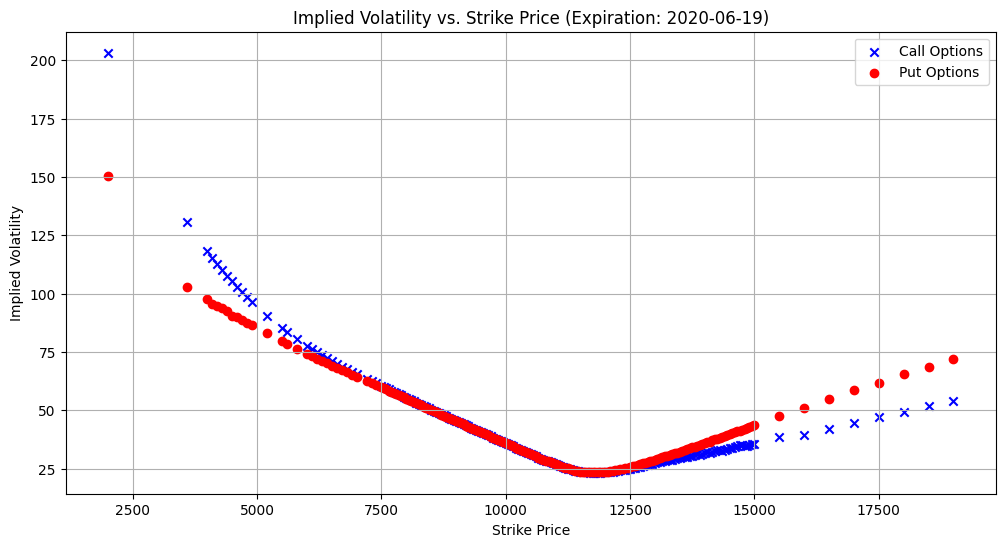

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
final_results_data = pd.read_csv('final_results_fixed_price.csv')

# Filter data for the common expiration date and only include rows with implied volatility
filtered_data = final_results_data[(final_results_data['EXPIR_DATE'] == '2020-06-19') & (final_results_data['IMP_VOLT'] > 0)]

# Separate the data into calls and puts
call_data = filtered_data[filtered_data['PUTCALLIND'] == 'CALL']
put_data = filtered_data[filtered_data['PUTCALLIND'] == 'PUT ']

# Sort by strike price
call_data = call_data.sort_values(by='STRIKE_PRC')
put_data = put_data.sort_values(by='STRIKE_PRC')

# Plot implied volatility against strike price for calls and puts
plt.figure(figsize=(12, 6))
plt.scatter(call_data['STRIKE_PRC'], call_data['IMP_VOLT'], c='b', marker='x', label='Call Options')
plt.scatter(put_data['STRIKE_PRC'], put_data['IMP_VOLT'], c='r', marker='o', label='Put Options')
plt.title('Implied Volatility vs. Strike Price (Expiration: 2020-06-19)')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.legend()
plt.grid(True)
plt.show()


**Ratio Spreads:** Buy and sell options in different transaction ratios, not just one-to-one. This can be customized to match the exact skew or smile that is observed in the market.

First, sort options with the same expiration date by strike price.

In [ ]:
import pandas as pd

# Load the data
final_results_data = pd.read_csv('final_results_fixed_price.csv')

# Remove the first row to avoid NaN in 'Price_Change' and 'Price_Change_Abs'
final_results_data = final_results_data.iloc[1:].reset_index(drop=True)

# Filter the data for options with the common expiration date of '2020-06-19'
filtered_data = final_results_data[final_results_data['EXPIR_DATE'] == '2020-06-19'].reset_index(drop=True)

# Separate the data into calls and puts
call_data = filtered_data[filtered_data['PUTCALLIND'] == 'CALL'].reset_index(drop=True)
put_data = filtered_data[filtered_data['PUTCALLIND'] == 'PUT '].reset_index(drop=True)

# Sort the data by 'STRIKE_PRC'
call_data = call_data.sort_values(by='STRIKE_PRC').reset_index(drop=True)
put_data = put_data.sort_values(by='STRIKE_PRC').reset_index(drop=True)

# Show a preview of the call data and put data
call_data.head(), put_data.head()

(   Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  STRIKE_PRC  \
 0           1  /GDAX20000F0.EX  2020-05-15  2020-06-19       CALL      2000.0   
 1           3  /GDAX36000F0.EX  2020-03-17  2020-06-19       CALL      3600.0   
 2           5  /GDAX40000F0.EX  2020-03-09  2020-06-19       CALL      4000.0   
 3           7  /GDAX41000F0.EX  2020-05-15  2020-06-19       CALL      4100.0   
 4           9  /GDAX42000F0.EX  2020-05-15  2020-06-19       CALL      4200.0   
 
    CF_CLOSE_x  IMP_VOLT  CF_CLOSE_y  DELTA          VEGA     THETA  \
 0      8323.3    203.25    10465.17    1.0  1.032345e-03  2.275812   
 1      6722.5    130.77     8939.10    1.0  3.903253e-08  3.330819   
 2      6322.5    118.17    10625.02    1.0  5.848615e-05  3.620396   
 3      6222.5    115.42    10465.17    1.0  5.432300e-04  4.666297   
 4      6122.6    112.74    10465.17    1.0 -1.221963e-04  4.781041   
 
           GAMMA  DELTA_HEDGE  VEGA_HEDGE  THETA_HEDGE   GAMMA_HEDGE  \
 0 -9.

**Ratio Spreads Strategy Implementation:**

Identify the options with the most significant skew or smile.
Determine the best ratio for buying and selling these options.
The code will loop through various buy-sell ratios to find the combination that offers the best risk-reward profile.

In [ ]:
import pandas as pd
import numpy as np

# Load the sorted options data
options_data = pd.read_csv('sorted_updated_merged_data_fixed.csv')

# Filter data for the common expiration date and only include rows with implied volatility
filtered_data = options_data[(options_data['EXPIR_DATE'] == '2020-06-19') & (options_data['IMP_VOLT'] > 0)]

# Separate the data into calls and puts
call_data = filtered_data[filtered_data['PUTCALLIND'] == 'CALL']
put_data = filtered_data[filtered_data['PUTCALLIND'] == 'PUT ']

# Sort by strike price
call_data = call_data.sort_values(by='STRIKE_PRC')
put_data = put_data.sort_values(by='STRIKE_PRC')

call_data.head(), put_data.head()

(     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
 377           1  /GDAX20000F0.EX  2020-05-15  2020-06-19       CALL   
 31            3  /GDAX36000F0.EX  2020-03-17  2020-06-19       CALL   
 20            5  /GDAX40000F0.EX  2020-03-09  2020-06-19       CALL   
 196           7  /GDAX41000F0.EX  2020-05-15  2020-06-19       CALL   
 202           9  /GDAX42000F0.EX  2020-05-15  2020-06-19       CALL   
 
      STRIKE_PRC  CF_CLOSE_x  IMP_VOLT         T  CF_CLOSE_y  
 377      2000.0      8323.3    203.25  0.095825    10465.17  
 31       3600.0      6722.5    130.77  0.257358     8939.10  
 20       4000.0      6322.5    118.17  0.279261    10625.02  
 196      4100.0      6222.5    115.42  0.095825    10465.17  
 202      4200.0      6122.6    112.74  0.095825    10465.17  ,
      Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
 90            2  /GDAX20000R0.EX  2020-04-30  2020-06-19       PUT    
 190           4  /GDAX36000R0.EX  2020-05-

Once the relevant options are identified, the next step is to determine the best ratio for buying and selling these options.

In [ ]:
# Function to find the optimal ratio spread combination
def find_ratio_spread_combination(options_data):
    best_combination = None
    best_profit = float('-inf')
    best_ratio = None

    # Convert the options data to a list of dictionaries for faster access
    options_list = options_data.to_dict(orient='records')

    # Loop through the options data to find a ratio spread combination
    for i, option_1 in enumerate(options_list):
        for j, option_2 in enumerate(options_list[i+1:], start=i+1):

            # Loop through different ratios
            for ratio in range(1, 101):  # ratio from 1 to 100

                # Calculate the profit for this ratio spread
                profit = ratio * option_1['CF_CLOSE_x'] - option_2['CF_CLOSE_x']

                # Update if this combination is better than the previous best
                if profit > best_profit:
                    best_profit = profit
                    best_combination = [option_1, option_2]
                    best_ratio = ratio

    return best_combination, best_ratio, best_profit

# Find the best ratio spread combination for calls and puts
best_call_combination, best_call_ratio, best_call_profit = find_ratio_spread_combination(call_data)
best_put_combination, best_put_ratio, best_put_profit = find_ratio_spread_combination(put_data)

best_call_combination, best_call_ratio, best_call_profit, best_put_combination, best_put_ratio, best_put_profit


([{'Unnamed: 0': 1,
   'Instrument': '/GDAX20000F0.EX',
   'CF_DATE': '2020-05-15',
   'EXPIR_DATE': '2020-06-19',
   'PUTCALLIND': 'CALL',
   'STRIKE_PRC': 2000.0,
   'CF_CLOSE_x': 8323.3,
   'IMP_VOLT': 203.25,
   'T': 0.0958247775496235,
   'CF_CLOSE_y': 10465.17},
  {'Unnamed: 0': 365,
   'Instrument': '/GDAX160000F0.EX',
   'CF_DATE': '2020-03-20',
   'EXPIR_DATE': '2020-06-19',
   'PUTCALLIND': 'CALL',
   'STRIKE_PRC': 16000.0,
   'CF_CLOSE_x': 0.1,
   'IMP_VOLT': 39.5,
   'T': 0.2491444216290212,
   'CF_CLOSE_y': 8928.95}],
 100,
 832329.8999999999,
 [{'Unnamed: 0': 376,
   'Instrument': '/GDAX185000R0.EX',
   'CF_DATE': '2020-05-15',
   'EXPIR_DATE': '2020-06-19',
   'PUTCALLIND': 'PUT ',
   'STRIKE_PRC': 18500.0,
   'CF_CLOSE_x': 8189.4,
   'IMP_VOLT': 68.53,
   'T': 0.0958247775496235,
   'CF_CLOSE_y': 10465.17},
  {'Unnamed: 0': 378,
   'Instrument': '/GDAX190000R0.EX',
   'CF_DATE': '2020-05-14',
   'EXPIR_DATE': '2020-06-19',
   'PUTCALLIND': 'PUT ',
   'STRIKE_PRC': 19000

### **Best Call Ratio Spread:**
- **Buy Option 1**: Strike Price = 2000, Premium = 8323.3, Implied Volatility = 203.25
- **Sell Option 2**: Strike Price = 16000, Premium = 0.1, Implied Volatility = 39.5%
- **Best Ratio**: 100
- **Best Profit**: $832,329.90

### **Best Put Ratio Spread:**
- **Buy Option 1**: Strike Price = 18500, Premium = 8189.4, Implied Volatility = 68.53%
- **Sell Option 2**: Strike Price = 19000, Premium = 8689.8, Implied Volatility = 71.82%
- **Best Ratio**: 100
- **Best Profit**: $810,250.20

In this strategy, you would buy 100 of Option 1 and sell 1 of Option 2 for both call and put options to achieve the best profit.

In [ ]:
# Create a DataFrame with the best combinations and metrics
best_combinations_ratio_spread_metrics = pd.DataFrame({
    'Best_Call_Combination': [str(best_call_combination)],
    'Best_Call_Ratio': [best_call_ratio],
    'Best_Call_Profit': [best_call_profit],
    'Best_Put_Combination': [str(best_put_combination)],
    'Best_Put_Ratio': [best_put_ratio],
    'Best_Put_Profit': [best_put_profit],
})

# Transpose the DataFrame to swap rows and columns
best_combinations_ratio_spread_metrics_transposed = best_combinations_ratio_spread_metrics.T

# Save the transposed DataFrame to a CSV file
csv_path = 'best_combinations_ratio_spread_metrics.csv'
best_combinations_ratio_spread_metrics_transposed.to_csv(csv_path, index=True)

csv_path

'best_combinations_ratio_spread_metrics.csv'

**Married Put Strategy:** In a married put strategy, an investor purchases an asset—such as shares of stock—and simultaneously purchases put options for an equivalent number of shares. The holder of a put option has the right to sell stock at the strike price, and each contract is worth 100 shares. An investor may choose to use this strategy as a way of protecting their downside risk when holding a stock. This strategy functions similarly to an insurance policy; it establishes a price floor in the event the stock's price falls sharply. This is why it's also known as a protective put.

For example, suppose an investor buys 100 shares of stock and buys one put option simultaneously. This strategy may be appealing for the investor because they are protected to the downside, in the event that a negative change in the stock price occurs. At the same time, the investor would be able to participate in every upside opportunity if the stock gains in value. The only disadvantage of this strategy is that if the stock does not fall in value, the investor loses the amount of the premium paid for the put option.

https://www.investopedia.com/trading/options-strategies/

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('combined_hedging_metrics.csv')

# Filter rows for put options
put_options = df[df['PUTCALLIND'] == 'PUT '].copy()

# Calculate the cost of purchasing 100 shares of the stock and 1 put option contract (which corresponds to 100 shares)
put_options['stock_cost'] = put_options['CF_CLOSE_y'] * 100
put_options['option_cost'] = put_options['CF_CLOSE_x'] * 1  # 1 option contract corresponds to 100 shares
put_options['total_cost'] = put_options['stock_cost'] + put_options['option_cost']

# Calculate potential profit/loss from selling the stock at its closing price the next day
put_options['stock_profit_next_day'] = (put_options['CF_CLOSE_y'].shift(-1) * 100) - put_options['stock_cost']

# Shift the 'CF_CLOSE_y' column to get the next day's stock price
put_options['stock_price_next_day'] = put_options['CF_CLOSE_y'].shift(-1)

# Calculate potential profit/loss from exercising the put option if the stock price falls below the strike price
put_options['option_profit'] = put_options.apply(lambda row: max(0, row['STRIKE_PRC'] - row['stock_price_next_day']) * 100 - row['option_cost'], axis=1)

# Calculate net profit/loss combining the stock and option profits/losses
put_options['net_profit'] = put_options['stock_profit_next_day'] + put_options['option_profit']

# Save the results to a CSV file
put_options[['CF_DATE', 'stock_profit_next_day', 'option_profit', 'net_profit']].to_csv('married_put_strategy.csv', index=False)


In [ ]:
# Compute the sum of all the net_profit values
total_net_profit = put_options['net_profit'].sum()
total_net_profit

23812309.200000003

**Short Strangle Strategy:**

In a short strangle strategy, a trader sells an out-of-the-money call option and an out-of-the-money put option on the same underlying asset with the same expiration date. The goal is to collect the premiums from selling both options. The maximum potential profit for the short strangle strategy is the sum of the premiums collected from selling both options. The risk, however, is theoretically unlimited since the stock can rise or fall indefinitely, and the trader would be obligated to buy or sell the stock at the strike price.

In [ ]:
import pandas as pd
import numpy as np

# Define the functions to select out-of-the-money call and put options
def select_out_of_the_money_call(group):
    return group[group['STRIKE_PRC'] < group['CF_CLOSE_y']].nlargest(1, 'STRIKE_PRC')

def select_out_of_the_money_put(group):
    return group[group['STRIKE_PRC'] > group['CF_CLOSE_y']].nsmallest(1, 'STRIKE_PRC')

# Load the data
df = pd.read_csv('combined_hedging_metrics.csv')

# Pre-processing and data cleaning
df_clean = df.dropna(subset=['CF_CLOSE_x', 'CF_CLOSE_y'])
calls_df_clean = df_clean[df_clean['PUTCALLIND'] == 'CALL']
puts_df_clean = df_clean[df_clean['PUTCALLIND'] == 'PUT ']

# Selecting out-of-the-money call and put options
out_of_the_money_calls = calls_df_clean.groupby('CF_DATE').apply(select_out_of_the_money_call).dropna().reset_index(drop=True)
out_of_the_money_puts = puts_df_clean.groupby('CF_DATE').apply(select_out_of_the_money_put).dropna().reset_index(drop=True)

# Merging the call and put options
long_strangle_df = pd.merge(out_of_the_money_calls, out_of_the_money_puts, on='CF_DATE', suffixes=('_call', '_put'))

# Computing profitability based on the next CF_DATE
df_sorted = df_clean.sort_values(by="CF_DATE")
df_sorted['CF_CLOSE_y_next'] = df_sorted['CF_CLOSE_y'].shift(-1)
long_strangle_with_next_price = pd.merge(long_strangle_df, df_sorted[['CF_DATE', 'CF_CLOSE_y_next']], on='CF_DATE', how='left')

# Calculating profit/loss for Short Strangle
long_strangle_with_next_price['profit_from_call_sold'] = np.where(
    long_strangle_with_next_price['CF_CLOSE_y_next'] > long_strangle_with_next_price['STRIKE_PRC_call'],
    -((long_strangle_with_next_price['CF_CLOSE_y_next'] - long_strangle_with_next_price['STRIKE_PRC_call']) * 100) + (long_strangle_with_next_price['CF_CLOSE_x_call'] * 100),
    long_strangle_with_next_price['CF_CLOSE_x_call'] * 100)

long_strangle_with_next_price['profit_from_put_sold'] = np.where(
    long_strangle_with_next_price['CF_CLOSE_y_next'] < long_strangle_with_next_price['STRIKE_PRC_put'],
    -((long_strangle_with_next_price['STRIKE_PRC_put'] - long_strangle_with_next_price['CF_CLOSE_y_next']) * 100) + (long_strangle_with_next_price['CF_CLOSE_x_put'] * 100),
    long_strangle_with_next_price['CF_CLOSE_x_put'] * 100)

long_strangle_with_next_price['total_profit_loss_sold'] = long_strangle_with_next_price['profit_from_call_sold'] + long_strangle_with_next_price['profit_from_put_sold']

# Keeping only relevant columns
relevant_columns = [
    'CF_DATE',
    'EXPIR_DATE_call', 'EXPIR_DATE_put',
    'STRIKE_PRC_call', 'STRIKE_PRC_put',
    'CF_CLOSE_x_call', 'CF_CLOSE_x_put',
    'CF_CLOSE_y_next',
    'profit_from_call_sold', 'profit_from_put_sold',
    'total_profit_loss_sold'
]

short_strangle_relevant = long_strangle_with_next_price[relevant_columns]

# Save the results to a new CSV file
short_strangle_relevant.to_csv('short_strangle_strategy_edited.csv', index=False)


In [ ]:
import pandas as pd

# Load the output CSV file
short_strangle_df = pd.read_csv('short_strangle_strategy_edited.csv')

# Compute the grand total of the total_profit_loss_sold column
grand_total_profit_loss = short_strangle_df['total_profit_loss_sold'].sum()

grand_total_profit_loss

18139150.0

In closing, here are the comparative total profits for all of the strategies discussed.

In [ ]:
import pandas as pd
import plotly.graph_objects as go

# Load the necessary data
combined_hedging_metrics_rounded = pd.read_csv('combined_hedging_metrics_rounded.csv')
combined_hedging_metrics_without_theta_rounded = pd.read_csv('combined_hedging_metrics_without_theta_rounded.csv')
final_shadow_delta_running_balance = pd.read_csv('shadow_delta_metrics_refined_profit_rounded.csv')
final_shadow_delta_running_balance_theta = pd.read_csv('shadow_delta_metrics_refined_profit_theta_rounded.csv')
pos_data = pd.read_csv('shadow_delta_metrics_smile_adjusted_rounded.csv')
pos_data_theta = pd.read_csv('shadow_delta_metrics_smile_adjusted_theta_rounded.csv')
best_combinations_data = pd.read_csv('best_combinations_ratio_spread_metrics.csv')
married_put_data = pd.read_csv('married_put_strategy.csv')
short_strangle_df = pd.read_csv('short_strangle_strategy_edited.csv')

# Calculate balances
balances = {
    "Delta Theta": combined_hedging_metrics_rounded["Combined_Running_Balance"].iloc[-1],
    "Delta": combined_hedging_metrics_without_theta_rounded["Combined_Running_Balance"].iloc[-1],
    "Shadow Delta": final_shadow_delta_running_balance["Shadow_Delta_Combined_Running_Balance"].iloc[-1],
    "Shadow Delta Theta": final_shadow_delta_running_balance_theta["Shadow_Delta_Combined_Running_Balance"].iloc[-1],
    "Shadow Delta Smile": pos_data["Adjusted_Shadow_Delta_Combined_Running_Balance"].iloc[-1],
    "Shadow Delta Smile Theta": pos_data_theta["Adjusted_Shadow_Delta_Combined_Running_Balance"].iloc[-1],
    "Ratio Spread Call": float(best_combinations_data.loc[best_combinations_data['Unnamed: 0'] == 'Best_Call_Profit', '0'].values[0]),
    "Ratio Spread Put": float(best_combinations_data.loc[best_combinations_data['Unnamed: 0'] == 'Best_Put_Profit', '0'].values[0]),
    "Married Put": married_put_data['net_profit'].sum(),
    "Short Strangle": short_strangle_df['total_profit_loss_sold'].sum()
}

# Sort balances in descending order
sorted_balances = {k: v for k, v in sorted(balances.items(), key=lambda item: item[1], reverse=True)}

# Print sorted balances
for desc, balance in sorted_balances.items():
    print(f"{desc}: ${balance:.2f}")

# Convert the sorted balances into lists for plotting
strategies = list(sorted_balances.keys())
values = list(sorted_balances.values())

# Create a bar chart with viridis color scale
fig = go.Figure(data=[go.Bar(
    x=strategies,
    y=values,
    marker=dict(
        color=values,
        colorscale='viridis',
        colorbar=dict(title='Balance')
    )
)])

# Update the layout
fig.update_layout(
    title="Balances Across Different Hedging Strategies",
    xaxis_title="Strategy",
    yaxis_title="Balance",
    template="plotly",
    xaxis_tickangle=-45,
    yaxis=dict(tickformat="$,.2f")
)

# Show the figure
fig.show()


Shadow Delta Smile Theta: $93088055.15
Delta Theta: $82606287.10
Shadow Delta Theta: $82482340.80
Married Put: $23812309.20
Short Strangle: $18139150.00
Shadow Delta Smile: $12469487.47
Shadow Delta: $1653544.98
Delta: $1648895.77
Ratio Spread Call: $832329.90
Ratio Spread Put: $810250.20


**Concluding Remarks**

This notebook has explored some of the intricacies of the Bakshi, Cao, and Chen (BCC) options pricing model, illustrating its advanced capabilities. By incorporating stochastic volatility and jumps in asset prices, the BCC model offers a nuanced and realistic portrayal of market behaviors.

Several hedging strategies, making use of delta, vega, theta, and gamma values, have been examined under the BCC framework. The dynamic nature of these strategies, especially in the context of stochastic parameters, requires regular adjustments, underscoring the importance of vigilance and adaptability for traders.

The visualizations provided offer clear insights into the relationships between different parameters, enabling a better understanding of how different factors influence options pricing and hedging outcomes. The dataset used further solidifies the theoretical assertions, offering a practical perspective on the application of the BCC model.

In summary, while the BCC model offers enhanced accuracy and flexibility, it also demands a deeper understanding and more proactive strategy adjustments. Traders and financial analysts looking to harness the full potential of this model will benefit from a thorough understanding of its components and the interactions therein.